In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_targets_t1_native_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1755717, 1576)
(1755717, 3)
validation
(308504, 1576)
(308504, 3)
test
(223783, 1576)
(223783, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1576)]            0         


 dense (Dense)               (None, 1024)              1614848   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 2304259 (8.79 MB)


Trainable params: 2304259 (8.79 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/176 [..............................] - ETA: 3:32 - loss: 1.1396 - STD: 0.1234 - MAE: 0.4355

  4/176 [..............................] - ETA: 4s - loss: 1.1089 - STD: 0.1195 - MAE: 0.4310  

  6/176 [>.............................] - ETA: 4s - loss: 1.0983 - STD: 0.1090 - MAE: 0.4312

  8/176 [>.............................] - ETA: 4s - loss: 1.0961 - STD: 0.0932 - MAE: 0.4335

 10/176 [>.............................] - ETA: 4s - loss: 1.0930 - STD: 0.0861 - MAE: 0.4342

 12/176 [=>............................] - ETA: 4s - loss: 1.0899 - STD: 0.0860 - MAE: 0.4338

 14/176 [=>............................] - ETA: 4s - loss: 1.0880 - STD: 0.0876 - MAE: 0.4333

 16/176 [=>............................] - ETA: 4s - loss: 1.0871 - STD: 0.0880 - MAE: 0.4332

 18/176 [==>...........................] - ETA: 4s - loss: 1.0852 - STD: 0.0868 - MAE: 0.4331

 20/176 [==>...........................] - ETA: 4s - loss: 1.0838 - STD: 0.0851 - MAE: 0.4331

 22/176 [==>...........................] - ETA: 4s - loss: 1.0827 - STD: 0.0825 - MAE: 0.4333

 24/176 [===>..........................] - ETA: 4s - loss: 1.0813 - STD: 0.0808 - MAE: 0.4333

 26/176 [===>..........................] - ETA: 4s - loss: 1.0800 - STD: 0.0810 - MAE: 0.4330

 28/176 [===>..........................] - ETA: 4s - loss: 1.0788 - STD: 0.0815 - MAE: 0.4327

 30/176 [====>.........................] - ETA: 4s - loss: 1.0771 - STD: 0.0811 - MAE: 0.4324

 32/176 [====>.........................] - ETA: 4s - loss: 1.0753 - STD: 0.0810 - MAE: 0.4320

 34/176 [====>.........................] - ETA: 4s - loss: 1.0730 - STD: 0.0804 - MAE: 0.4316

 36/176 [=====>........................] - ETA: 4s - loss: 1.0701 - STD: 0.0805 - MAE: 0.4309

 38/176 [=====>........................] - ETA: 4s - loss: 1.0664 - STD: 0.0812 - MAE: 0.4299

 40/176 [=====>........................] - ETA: 4s - loss: 1.0620 - STD: 0.0826 - MAE: 0.4286

 42/176 [======>.......................] - ETA: 4s - loss: 1.0572 - STD: 0.0856 - MAE: 0.4268

 44/176 [======>.......................] - ETA: 4s - loss: 1.0525 - STD: 0.0892 - MAE: 0.4248

 46/176 [======>.......................] - ETA: 4s - loss: 1.0471 - STD: 0.0917 - MAE: 0.4231

 48/176 [=======>......................] - ETA: 4s - loss: 1.0423 - STD: 0.0958 - MAE: 0.4208

 50/176 [=======>......................] - ETA: 4s - loss: 1.0376 - STD: 0.0997 - MAE: 0.4187

 52/176 [=======>......................] - ETA: 4s - loss: 1.0331 - STD: 0.1033 - MAE: 0.4167

 54/176 [========>.....................] - ETA: 4s - loss: 1.0288 - STD: 0.1075 - MAE: 0.4145

 56/176 [========>.....................] - ETA: 4s - loss: 1.0244 - STD: 0.1108 - MAE: 0.4126

 58/176 [========>.....................] - ETA: 3s - loss: 1.0205 - STD: 0.1144 - MAE: 0.4106

 60/176 [=========>....................] - ETA: 3s - loss: 1.0165 - STD: 0.1172 - MAE: 0.4089

 62/176 [=========>....................] - ETA: 3s - loss: 1.0128 - STD: 0.1204 - MAE: 0.4071

 64/176 [=========>....................] - ETA: 3s - loss: 1.0093 - STD: 0.1229 - MAE: 0.4056

 66/176 [==========>...................] - ETA: 3s - loss: 1.0060 - STD: 0.1256 - MAE: 0.4040

 68/176 [==========>...................] - ETA: 3s - loss: 1.0027 - STD: 0.1277 - MAE: 0.4027

 70/176 [==========>...................] - ETA: 3s - loss: 0.9995 - STD: 0.1298 - MAE: 0.4014

 72/176 [===========>..................] - ETA: 3s - loss: 0.9964 - STD: 0.1316 - MAE: 0.4002

 74/176 [===========>..................] - ETA: 3s - loss: 0.9936 - STD: 0.1335 - MAE: 0.3990

 76/176 [===========>..................] - ETA: 3s - loss: 0.9906 - STD: 0.1353 - MAE: 0.3978

 78/176 [============>.................] - ETA: 3s - loss: 0.9877 - STD: 0.1374 - MAE: 0.3966

 80/176 [============>.................] - ETA: 3s - loss: 0.9850 - STD: 0.1392 - MAE: 0.3954

 82/176 [============>.................] - ETA: 3s - loss: 0.9823 - STD: 0.1410 - MAE: 0.3943

 84/176 [=============>................] - ETA: 3s - loss: 0.9795 - STD: 0.1427 - MAE: 0.3931

 86/176 [=============>................] - ETA: 3s - loss: 0.9773 - STD: 0.1442 - MAE: 0.3921

 88/176 [==============>...............] - ETA: 2s - loss: 0.9748 - STD: 0.1460 - MAE: 0.3910

 90/176 [==============>...............] - ETA: 3s - loss: 0.9730 - STD: 0.1475 - MAE: 0.3900

 93/176 [==============>...............] - ETA: 3s - loss: 0.9693 - STD: 0.1499 - MAE: 0.3885

 96/176 [===============>..............] - ETA: 3s - loss: 0.9659 - STD: 0.1519 - MAE: 0.3871

 99/176 [===============>..............] - ETA: 2s - loss: 0.9624 - STD: 0.1540 - MAE: 0.3857

101/176 [================>.............] - ETA: 2s - loss: 0.9602 - STD: 0.1554 - MAE: 0.3847

103/176 [================>.............] - ETA: 2s - loss: 0.9580 - STD: 0.1569 - MAE: 0.3837

105/176 [================>.............] - ETA: 2s - loss: 0.9560 - STD: 0.1583 - MAE: 0.3828

107/176 [=================>............] - ETA: 2s - loss: 0.9538 - STD: 0.1595 - MAE: 0.3820

109/176 [=================>............] - ETA: 2s - loss: 0.9517 - STD: 0.1606 - MAE: 0.3811

111/176 [=================>............] - ETA: 2s - loss: 0.9500 - STD: 0.1619 - MAE: 0.3803

113/176 [==================>...........] - ETA: 2s - loss: 0.9479 - STD: 0.1631 - MAE: 0.3795

115/176 [==================>...........] - ETA: 2s - loss: 0.9458 - STD: 0.1643 - MAE: 0.3786

117/176 [==================>...........] - ETA: 2s - loss: 0.9438 - STD: 0.1655 - MAE: 0.3778

119/176 [===================>..........] - ETA: 2s - loss: 0.9418 - STD: 0.1667 - MAE: 0.3769

121/176 [===================>..........] - ETA: 2s - loss: 0.9400 - STD: 0.1678 - MAE: 0.3761

123/176 [===================>..........] - ETA: 1s - loss: 0.9383 - STD: 0.1690 - MAE: 0.3753

125/176 [====================>.........] - ETA: 1s - loss: 0.9364 - STD: 0.1702 - MAE: 0.3745

127/176 [====================>.........] - ETA: 1s - loss: 0.9347 - STD: 0.1714 - MAE: 0.3737

129/176 [====================>.........] - ETA: 1s - loss: 0.9335 - STD: 0.1725 - MAE: 0.3731

131/176 [=====================>........] - ETA: 1s - loss: 0.9319 - STD: 0.1732 - MAE: 0.3725

133/176 [=====================>........] - ETA: 1s - loss: 0.9303 - STD: 0.1743 - MAE: 0.3717

135/176 [======================>.......] - ETA: 1s - loss: 0.9288 - STD: 0.1754 - MAE: 0.3710

137/176 [======================>.......] - ETA: 1s - loss: 0.9271 - STD: 0.1761 - MAE: 0.3704

139/176 [======================>.......] - ETA: 1s - loss: 0.9256 - STD: 0.1771 - MAE: 0.3698

141/176 [=======================>......] - ETA: 1s - loss: 0.9241 - STD: 0.1780 - MAE: 0.3691

143/176 [=======================>......] - ETA: 1s - loss: 0.9226 - STD: 0.1788 - MAE: 0.3685

145/176 [=======================>......] - ETA: 1s - loss: 0.9212 - STD: 0.1798 - MAE: 0.3679

147/176 [========================>.....] - ETA: 1s - loss: 0.9196 - STD: 0.1807 - MAE: 0.3672

149/176 [========================>.....] - ETA: 0s - loss: 0.9181 - STD: 0.1816 - MAE: 0.3665

151/176 [========================>.....] - ETA: 0s - loss: 0.9166 - STD: 0.1824 - MAE: 0.3659

153/176 [=========================>....] - ETA: 0s - loss: 0.9152 - STD: 0.1832 - MAE: 0.3653

155/176 [=========================>....] - ETA: 0s - loss: 0.9138 - STD: 0.1840 - MAE: 0.3647

157/176 [=========================>....] - ETA: 0s - loss: 0.9125 - STD: 0.1848 - MAE: 0.3642

159/176 [==========================>...] - ETA: 0s - loss: 0.9112 - STD: 0.1856 - MAE: 0.3636

161/176 [==========================>...] - ETA: 0s - loss: 0.9098 - STD: 0.1865 - MAE: 0.3630

163/176 [==========================>...] - ETA: 0s - loss: 0.9085 - STD: 0.1873 - MAE: 0.3624

165/176 [===========================>..] - ETA: 0s - loss: 0.9080 - STD: 0.1881 - MAE: 0.3619

167/176 [===========================>..] - ETA: 0s - loss: 0.9069 - STD: 0.1887 - MAE: 0.3615

169/176 [===========================>..] - ETA: 0s - loss: 0.9060 - STD: 0.1894 - MAE: 0.3611

171/176 [============================>.] - ETA: 0s - loss: 0.9048 - STD: 0.1902 - MAE: 0.3605

173/176 [============================>.] - ETA: 0s - loss: 0.9037 - STD: 0.1907 - MAE: 0.3601

175/176 [============================>.] - ETA: 0s - loss: 0.9026 - STD: 0.1914 - MAE: 0.3596

176/176 [==============================] - 9s 45ms/step - loss: 0.9020 - STD: 0.1916 - MAE: 0.3594 - val_loss: 0.8110 - val_STD: 0.2638 - val_MAE: 0.3095


Epoch 2/10000


  1/176 [..............................] - ETA: 11s - loss: 0.8086 - STD: 0.2658 - MAE: 0.3103

  3/176 [..............................] - ETA: 5s - loss: 0.8041 - STD: 0.2475 - MAE: 0.3181 

  5/176 [..............................] - ETA: 5s - loss: 0.8010 - STD: 0.2501 - MAE: 0.3161

  7/176 [>.............................] - ETA: 5s - loss: 0.8002 - STD: 0.2528 - MAE: 0.3146

  9/176 [>.............................] - ETA: 5s - loss: 0.7996 - STD: 0.2511 - MAE: 0.3153

 11/176 [>.............................] - ETA: 5s - loss: 0.7994 - STD: 0.2517 - MAE: 0.3150

 13/176 [=>............................] - ETA: 5s - loss: 0.7993 - STD: 0.2523 - MAE: 0.3147

 15/176 [=>............................] - ETA: 5s - loss: 0.7985 - STD: 0.2522 - MAE: 0.3146

 17/176 [=>............................] - ETA: 5s - loss: 0.7981 - STD: 0.2515 - MAE: 0.3148

 19/176 [==>...........................] - ETA: 5s - loss: 0.7981 - STD: 0.2525 - MAE: 0.3143

 21/176 [==>...........................] - ETA: 5s - loss: 0.7980 - STD: 0.2533 - MAE: 0.3139

 23/176 [==>...........................] - ETA: 5s - loss: 0.7981 - STD: 0.2527 - MAE: 0.3142

 25/176 [===>..........................] - ETA: 4s - loss: 0.7968 - STD: 0.2529 - MAE: 0.3138

 27/176 [===>..........................] - ETA: 4s - loss: 0.7968 - STD: 0.2532 - MAE: 0.3137

 29/176 [===>..........................] - ETA: 4s - loss: 0.7958 - STD: 0.2535 - MAE: 0.3134

 31/176 [====>.........................] - ETA: 4s - loss: 0.7953 - STD: 0.2535 - MAE: 0.3132

 33/176 [====>.........................] - ETA: 4s - loss: 0.7947 - STD: 0.2538 - MAE: 0.3130

 35/176 [====>.........................] - ETA: 4s - loss: 0.7945 - STD: 0.2539 - MAE: 0.3128

 37/176 [=====>........................] - ETA: 4s - loss: 0.7942 - STD: 0.2542 - MAE: 0.3126

 39/176 [=====>........................] - ETA: 4s - loss: 0.7939 - STD: 0.2548 - MAE: 0.3123

 41/176 [=====>........................] - ETA: 4s - loss: 0.7938 - STD: 0.2546 - MAE: 0.3124

 43/176 [======>.......................] - ETA: 4s - loss: 0.7932 - STD: 0.2544 - MAE: 0.3124

 45/176 [======>.......................] - ETA: 4s - loss: 0.7936 - STD: 0.2548 - MAE: 0.3122

 47/176 [=======>......................] - ETA: 4s - loss: 0.7932 - STD: 0.2549 - MAE: 0.3121

 49/176 [=======>......................] - ETA: 4s - loss: 0.7933 - STD: 0.2553 - MAE: 0.3119

 51/176 [=======>......................] - ETA: 4s - loss: 0.7927 - STD: 0.2551 - MAE: 0.3119

 53/176 [========>.....................] - ETA: 4s - loss: 0.7925 - STD: 0.2553 - MAE: 0.3117

 55/176 [========>.....................] - ETA: 3s - loss: 0.7917 - STD: 0.2557 - MAE: 0.3114

 57/176 [========>.....................] - ETA: 3s - loss: 0.7907 - STD: 0.2557 - MAE: 0.3111

 59/176 [=========>....................] - ETA: 3s - loss: 0.7903 - STD: 0.2559 - MAE: 0.3109

 61/176 [=========>....................] - ETA: 3s - loss: 0.7898 - STD: 0.2562 - MAE: 0.3107

 63/176 [=========>....................] - ETA: 3s - loss: 0.7896 - STD: 0.2567 - MAE: 0.3104

 65/176 [==========>...................] - ETA: 3s - loss: 0.7897 - STD: 0.2569 - MAE: 0.3103

 67/176 [==========>...................] - ETA: 3s - loss: 0.7894 - STD: 0.2569 - MAE: 0.3103

 69/176 [==========>...................] - ETA: 3s - loss: 0.7896 - STD: 0.2571 - MAE: 0.3102

 71/176 [===========>..................] - ETA: 3s - loss: 0.7893 - STD: 0.2573 - MAE: 0.3100

 73/176 [===========>..................] - ETA: 3s - loss: 0.7890 - STD: 0.2573 - MAE: 0.3100

 75/176 [===========>..................] - ETA: 3s - loss: 0.7888 - STD: 0.2572 - MAE: 0.3100

 77/176 [============>.................] - ETA: 3s - loss: 0.7883 - STD: 0.2575 - MAE: 0.3098

 79/176 [============>.................] - ETA: 3s - loss: 0.7880 - STD: 0.2575 - MAE: 0.3097

 81/176 [============>.................] - ETA: 3s - loss: 0.7874 - STD: 0.2577 - MAE: 0.3094

 83/176 [=============>................] - ETA: 3s - loss: 0.7868 - STD: 0.2580 - MAE: 0.3092

 85/176 [=============>................] - ETA: 3s - loss: 0.7864 - STD: 0.2583 - MAE: 0.3089

 87/176 [=============>................] - ETA: 2s - loss: 0.7864 - STD: 0.2585 - MAE: 0.3088

 89/176 [==============>...............] - ETA: 2s - loss: 0.7861 - STD: 0.2586 - MAE: 0.3087

 91/176 [==============>...............] - ETA: 2s - loss: 0.7862 - STD: 0.2589 - MAE: 0.3086

 93/176 [==============>...............] - ETA: 2s - loss: 0.7862 - STD: 0.2591 - MAE: 0.3085

 95/176 [===============>..............] - ETA: 2s - loss: 0.7865 - STD: 0.2591 - MAE: 0.3085

 97/176 [===============>..............] - ETA: 2s - loss: 0.7864 - STD: 0.2591 - MAE: 0.3085

 99/176 [===============>..............] - ETA: 2s - loss: 0.7861 - STD: 0.2593 - MAE: 0.3083

101/176 [================>.............] - ETA: 2s - loss: 0.7858 - STD: 0.2592 - MAE: 0.3083

103/176 [================>.............] - ETA: 2s - loss: 0.7854 - STD: 0.2593 - MAE: 0.3082

105/176 [================>.............] - ETA: 2s - loss: 0.7851 - STD: 0.2594 - MAE: 0.3081

107/176 [=================>............] - ETA: 2s - loss: 0.7848 - STD: 0.2595 - MAE: 0.3080

109/176 [=================>............] - ETA: 2s - loss: 0.7845 - STD: 0.2596 - MAE: 0.3079

111/176 [=================>............] - ETA: 2s - loss: 0.7843 - STD: 0.2598 - MAE: 0.3077

113/176 [==================>...........] - ETA: 2s - loss: 0.7840 - STD: 0.2599 - MAE: 0.3076

115/176 [==================>...........] - ETA: 2s - loss: 0.7836 - STD: 0.2600 - MAE: 0.3075

117/176 [==================>...........] - ETA: 1s - loss: 0.7831 - STD: 0.2602 - MAE: 0.3073

119/176 [===================>..........] - ETA: 1s - loss: 0.7827 - STD: 0.2603 - MAE: 0.3071

121/176 [===================>..........] - ETA: 1s - loss: 0.7822 - STD: 0.2605 - MAE: 0.3069

123/176 [===================>..........] - ETA: 1s - loss: 0.7820 - STD: 0.2607 - MAE: 0.3068

125/176 [====================>.........] - ETA: 1s - loss: 0.7819 - STD: 0.2608 - MAE: 0.3067

127/176 [====================>.........] - ETA: 1s - loss: 0.7816 - STD: 0.2611 - MAE: 0.3065

129/176 [====================>.........] - ETA: 1s - loss: 0.7813 - STD: 0.2611 - MAE: 0.3064

131/176 [=====================>........] - ETA: 1s - loss: 0.7811 - STD: 0.2613 - MAE: 0.3063

133/176 [=====================>........] - ETA: 1s - loss: 0.7810 - STD: 0.2614 - MAE: 0.3063

135/176 [======================>.......] - ETA: 1s - loss: 0.7808 - STD: 0.2615 - MAE: 0.3061

137/176 [======================>.......] - ETA: 1s - loss: 0.7807 - STD: 0.2616 - MAE: 0.3061

139/176 [======================>.......] - ETA: 1s - loss: 0.7805 - STD: 0.2616 - MAE: 0.3060

141/176 [=======================>......] - ETA: 1s - loss: 0.7801 - STD: 0.2618 - MAE: 0.3058

143/176 [=======================>......] - ETA: 1s - loss: 0.7799 - STD: 0.2618 - MAE: 0.3058

145/176 [=======================>......] - ETA: 1s - loss: 0.7797 - STD: 0.2619 - MAE: 0.3057

147/176 [========================>.....] - ETA: 0s - loss: 0.7795 - STD: 0.2620 - MAE: 0.3056

149/176 [========================>.....] - ETA: 0s - loss: 0.7795 - STD: 0.2622 - MAE: 0.3055

151/176 [========================>.....] - ETA: 0s - loss: 0.7794 - STD: 0.2622 - MAE: 0.3055

153/176 [=========================>....] - ETA: 0s - loss: 0.7792 - STD: 0.2623 - MAE: 0.3054

155/176 [=========================>....] - ETA: 0s - loss: 0.7789 - STD: 0.2624 - MAE: 0.3053

157/176 [=========================>....] - ETA: 0s - loss: 0.7787 - STD: 0.2624 - MAE: 0.3053

159/176 [==========================>...] - ETA: 0s - loss: 0.7785 - STD: 0.2625 - MAE: 0.3051

161/176 [==========================>...] - ETA: 0s - loss: 0.7782 - STD: 0.2625 - MAE: 0.3051

163/176 [==========================>...] - ETA: 0s - loss: 0.7780 - STD: 0.2626 - MAE: 0.3050

165/176 [===========================>..] - ETA: 0s - loss: 0.7779 - STD: 0.2627 - MAE: 0.3049

167/176 [===========================>..] - ETA: 0s - loss: 0.7779 - STD: 0.2629 - MAE: 0.3048

169/176 [===========================>..] - ETA: 0s - loss: 0.7777 - STD: 0.2629 - MAE: 0.3048

171/176 [============================>.] - ETA: 0s - loss: 0.7775 - STD: 0.2631 - MAE: 0.3047

173/176 [============================>.] - ETA: 0s - loss: 0.7773 - STD: 0.2631 - MAE: 0.3046

175/176 [============================>.] - ETA: 0s - loss: 0.7771 - STD: 0.2632 - MAE: 0.3045

176/176 [==============================] - 7s 39ms/step - loss: 0.7770 - STD: 0.2632 - MAE: 0.3045 - val_loss: 0.7967 - val_STD: 0.2699 - val_MAE: 0.3028


Epoch 3/10000


  1/176 [..............................] - ETA: 11s - loss: 0.7585 - STD: 0.2637 - MAE: 0.3008

  3/176 [..............................] - ETA: 6s - loss: 0.7569 - STD: 0.2693 - MAE: 0.2974 

  5/176 [..............................] - ETA: 5s - loss: 0.7597 - STD: 0.2684 - MAE: 0.2986

  7/176 [>.............................] - ETA: 5s - loss: 0.7614 - STD: 0.2680 - MAE: 0.2992

  9/176 [>.............................] - ETA: 5s - loss: 0.7644 - STD: 0.2688 - MAE: 0.2994

 11/176 [>.............................] - ETA: 5s - loss: 0.7646 - STD: 0.2708 - MAE: 0.2983

 13/176 [=>............................] - ETA: 5s - loss: 0.7649 - STD: 0.2696 - MAE: 0.2990

 15/176 [=>............................] - ETA: 5s - loss: 0.7645 - STD: 0.2698 - MAE: 0.2989

 17/176 [=>............................] - ETA: 5s - loss: 0.7633 - STD: 0.2699 - MAE: 0.2985

 19/176 [==>...........................] - ETA: 5s - loss: 0.7628 - STD: 0.2697 - MAE: 0.2985

 21/176 [==>...........................] - ETA: 5s - loss: 0.7622 - STD: 0.2698 - MAE: 0.2983

 23/176 [==>...........................] - ETA: 5s - loss: 0.7613 - STD: 0.2704 - MAE: 0.2978

 25/176 [===>..........................] - ETA: 5s - loss: 0.7610 - STD: 0.2705 - MAE: 0.2977

 27/176 [===>..........................] - ETA: 5s - loss: 0.7608 - STD: 0.2706 - MAE: 0.2976

 29/176 [===>..........................] - ETA: 4s - loss: 0.7607 - STD: 0.2710 - MAE: 0.2973

 31/176 [====>.........................] - ETA: 4s - loss: 0.7613 - STD: 0.2712 - MAE: 0.2974

 33/176 [====>.........................] - ETA: 4s - loss: 0.7610 - STD: 0.2706 - MAE: 0.2976

 35/176 [====>.........................] - ETA: 4s - loss: 0.7606 - STD: 0.2707 - MAE: 0.2975

 37/176 [=====>........................] - ETA: 4s - loss: 0.7603 - STD: 0.2707 - MAE: 0.2974

 39/176 [=====>........................] - ETA: 4s - loss: 0.7598 - STD: 0.2704 - MAE: 0.2975

 41/176 [=====>........................] - ETA: 4s - loss: 0.7592 - STD: 0.2707 - MAE: 0.2972

 43/176 [======>.......................] - ETA: 4s - loss: 0.7588 - STD: 0.2709 - MAE: 0.2970

 45/176 [======>.......................] - ETA: 4s - loss: 0.7586 - STD: 0.2710 - MAE: 0.2968

 47/176 [=======>......................] - ETA: 4s - loss: 0.7580 - STD: 0.2712 - MAE: 0.2966

 49/176 [=======>......................] - ETA: 4s - loss: 0.7572 - STD: 0.2714 - MAE: 0.2964

 51/176 [=======>......................] - ETA: 4s - loss: 0.7568 - STD: 0.2714 - MAE: 0.2962

 53/176 [========>.....................] - ETA: 4s - loss: 0.7563 - STD: 0.2717 - MAE: 0.2960

 55/176 [========>.....................] - ETA: 4s - loss: 0.7559 - STD: 0.2717 - MAE: 0.2959

 57/176 [========>.....................] - ETA: 3s - loss: 0.7558 - STD: 0.2718 - MAE: 0.2959

 59/176 [=========>....................] - ETA: 3s - loss: 0.7554 - STD: 0.2720 - MAE: 0.2957

 61/176 [=========>....................] - ETA: 3s - loss: 0.7552 - STD: 0.2720 - MAE: 0.2956

 63/176 [=========>....................] - ETA: 3s - loss: 0.7550 - STD: 0.2720 - MAE: 0.2956

 65/176 [==========>...................] - ETA: 3s - loss: 0.7548 - STD: 0.2722 - MAE: 0.2955

 67/176 [==========>...................] - ETA: 3s - loss: 0.7546 - STD: 0.2723 - MAE: 0.2954

 69/176 [==========>...................] - ETA: 3s - loss: 0.7543 - STD: 0.2723 - MAE: 0.2953

 71/176 [===========>..................] - ETA: 3s - loss: 0.7541 - STD: 0.2724 - MAE: 0.2952

 73/176 [===========>..................] - ETA: 3s - loss: 0.7537 - STD: 0.2724 - MAE: 0.2951

 75/176 [===========>..................] - ETA: 3s - loss: 0.7536 - STD: 0.2726 - MAE: 0.2951

 77/176 [============>.................] - ETA: 3s - loss: 0.7535 - STD: 0.2724 - MAE: 0.2951

 79/176 [============>.................] - ETA: 3s - loss: 0.7536 - STD: 0.2725 - MAE: 0.2951

 81/176 [============>.................] - ETA: 3s - loss: 0.7535 - STD: 0.2726 - MAE: 0.2950

 83/176 [=============>................] - ETA: 3s - loss: 0.7534 - STD: 0.2725 - MAE: 0.2951

 85/176 [=============>................] - ETA: 3s - loss: 0.7530 - STD: 0.2725 - MAE: 0.2950

 87/176 [=============>................] - ETA: 2s - loss: 0.7526 - STD: 0.2726 - MAE: 0.2949

 89/176 [==============>...............] - ETA: 2s - loss: 0.7523 - STD: 0.2726 - MAE: 0.2948

 91/176 [==============>...............] - ETA: 2s - loss: 0.7519 - STD: 0.2728 - MAE: 0.2946

 93/176 [==============>...............] - ETA: 2s - loss: 0.7519 - STD: 0.2729 - MAE: 0.2946

 95/176 [===============>..............] - ETA: 2s - loss: 0.7515 - STD: 0.2729 - MAE: 0.2945

 97/176 [===============>..............] - ETA: 2s - loss: 0.7510 - STD: 0.2731 - MAE: 0.2943

 99/176 [===============>..............] - ETA: 2s - loss: 0.7507 - STD: 0.2732 - MAE: 0.2942

101/176 [================>.............] - ETA: 2s - loss: 0.7505 - STD: 0.2732 - MAE: 0.2941

103/176 [================>.............] - ETA: 2s - loss: 0.7503 - STD: 0.2733 - MAE: 0.2940

105/176 [================>.............] - ETA: 2s - loss: 0.7499 - STD: 0.2733 - MAE: 0.2940

108/176 [=================>............] - ETA: 2s - loss: 0.7503 - STD: 0.2736 - MAE: 0.2939

110/176 [=================>............] - ETA: 2s - loss: 0.7502 - STD: 0.2737 - MAE: 0.2938

112/176 [==================>...........] - ETA: 2s - loss: 0.7504 - STD: 0.2738 - MAE: 0.2938

114/176 [==================>...........] - ETA: 2s - loss: 0.7503 - STD: 0.2739 - MAE: 0.2938

116/176 [==================>...........] - ETA: 1s - loss: 0.7502 - STD: 0.2739 - MAE: 0.2937

118/176 [===================>..........] - ETA: 1s - loss: 0.7504 - STD: 0.2740 - MAE: 0.2937

120/176 [===================>..........] - ETA: 1s - loss: 0.7507 - STD: 0.2742 - MAE: 0.2937

122/176 [===================>..........] - ETA: 1s - loss: 0.7509 - STD: 0.2740 - MAE: 0.2939

124/176 [====================>.........] - ETA: 1s - loss: 0.7517 - STD: 0.2741 - MAE: 0.2939

126/176 [====================>.........] - ETA: 1s - loss: 0.7522 - STD: 0.2741 - MAE: 0.2940

128/176 [====================>.........] - ETA: 1s - loss: 0.7522 - STD: 0.2738 - MAE: 0.2942

130/176 [=====================>........] - ETA: 1s - loss: 0.7521 - STD: 0.2738 - MAE: 0.2942

132/176 [=====================>........] - ETA: 1s - loss: 0.7520 - STD: 0.2737 - MAE: 0.2942

134/176 [=====================>........] - ETA: 1s - loss: 0.7521 - STD: 0.2736 - MAE: 0.2943

136/176 [======================>.......] - ETA: 1s - loss: 0.7520 - STD: 0.2737 - MAE: 0.2942

138/176 [======================>.......] - ETA: 1s - loss: 0.7517 - STD: 0.2735 - MAE: 0.2943

140/176 [======================>.......] - ETA: 1s - loss: 0.7517 - STD: 0.2736 - MAE: 0.2942

142/176 [=======================>......] - ETA: 1s - loss: 0.7516 - STD: 0.2735 - MAE: 0.2942

144/176 [=======================>......] - ETA: 1s - loss: 0.7513 - STD: 0.2736 - MAE: 0.2941

146/176 [=======================>......] - ETA: 1s - loss: 0.7511 - STD: 0.2736 - MAE: 0.2941

148/176 [========================>.....] - ETA: 0s - loss: 0.7509 - STD: 0.2738 - MAE: 0.2940

150/176 [========================>.....] - ETA: 0s - loss: 0.7506 - STD: 0.2738 - MAE: 0.2939

152/176 [========================>.....] - ETA: 0s - loss: 0.7504 - STD: 0.2739 - MAE: 0.2938

154/176 [=========================>....] - ETA: 0s - loss: 0.7501 - STD: 0.2740 - MAE: 0.2937

156/176 [=========================>....] - ETA: 0s - loss: 0.7499 - STD: 0.2740 - MAE: 0.2936

158/176 [=========================>....] - ETA: 0s - loss: 0.7496 - STD: 0.2741 - MAE: 0.2936

160/176 [==========================>...] - ETA: 0s - loss: 0.7494 - STD: 0.2742 - MAE: 0.2934

162/176 [==========================>...] - ETA: 0s - loss: 0.7493 - STD: 0.2742 - MAE: 0.2934

164/176 [==========================>...] - ETA: 0s - loss: 0.7492 - STD: 0.2742 - MAE: 0.2934

166/176 [===========================>..] - ETA: 0s - loss: 0.7490 - STD: 0.2743 - MAE: 0.2933

168/176 [===========================>..] - ETA: 0s - loss: 0.7491 - STD: 0.2744 - MAE: 0.2933

170/176 [===========================>..] - ETA: 0s - loss: 0.7491 - STD: 0.2744 - MAE: 0.2933

172/176 [============================>.] - ETA: 0s - loss: 0.7496 - STD: 0.2746 - MAE: 0.2933

174/176 [============================>.] - ETA: 0s - loss: 0.7503 - STD: 0.2748 - MAE: 0.2933

176/176 [==============================] - ETA: 0s - loss: 0.7505 - STD: 0.2746 - MAE: 0.2935

176/176 [==============================] - 7s 39ms/step - loss: 0.7505 - STD: 0.2746 - MAE: 0.2935 - val_loss: 0.7674 - val_STD: 0.2828 - val_MAE: 0.2904


Epoch 4/10000


  1/176 [..............................] - ETA: 12s - loss: 0.7441 - STD: 0.2841 - MAE: 0.2874

  3/176 [..............................] - ETA: 6s - loss: 0.7549 - STD: 0.2701 - MAE: 0.2971 

  5/176 [..............................] - ETA: 5s - loss: 0.7564 - STD: 0.2659 - MAE: 0.2996

  7/176 [>.............................] - ETA: 5s - loss: 0.7538 - STD: 0.2650 - MAE: 0.2995

  9/176 [>.............................] - ETA: 5s - loss: 0.7505 - STD: 0.2654 - MAE: 0.2986

 11/176 [>.............................] - ETA: 5s - loss: 0.7472 - STD: 0.2660 - MAE: 0.2976

 13/176 [=>............................] - ETA: 5s - loss: 0.7451 - STD: 0.2671 - MAE: 0.2966

 15/176 [=>............................] - ETA: 5s - loss: 0.7438 - STD: 0.2690 - MAE: 0.2953

 17/176 [=>............................] - ETA: 5s - loss: 0.7423 - STD: 0.2700 - MAE: 0.2945

 19/176 [==>...........................] - ETA: 5s - loss: 0.7393 - STD: 0.2717 - MAE: 0.2930

 21/176 [==>...........................] - ETA: 5s - loss: 0.7389 - STD: 0.2725 - MAE: 0.2924

 23/176 [==>...........................] - ETA: 5s - loss: 0.7381 - STD: 0.2736 - MAE: 0.2916

 25/176 [===>..........................] - ETA: 5s - loss: 0.7371 - STD: 0.2742 - MAE: 0.2911

 27/176 [===>..........................] - ETA: 4s - loss: 0.7369 - STD: 0.2747 - MAE: 0.2908

 29/176 [===>..........................] - ETA: 4s - loss: 0.7364 - STD: 0.2752 - MAE: 0.2905

 31/176 [====>.........................] - ETA: 4s - loss: 0.7365 - STD: 0.2755 - MAE: 0.2903

 33/176 [====>.........................] - ETA: 4s - loss: 0.7366 - STD: 0.2762 - MAE: 0.2900

 35/176 [====>.........................] - ETA: 4s - loss: 0.7370 - STD: 0.2762 - MAE: 0.2900

 37/176 [=====>........................] - ETA: 4s - loss: 0.7375 - STD: 0.2766 - MAE: 0.2900

 39/176 [=====>........................] - ETA: 4s - loss: 0.7385 - STD: 0.2767 - MAE: 0.2901

 41/176 [=====>........................] - ETA: 4s - loss: 0.7400 - STD: 0.2772 - MAE: 0.2902

 43/176 [======>.......................] - ETA: 4s - loss: 0.7401 - STD: 0.2765 - MAE: 0.2906

 45/176 [======>.......................] - ETA: 4s - loss: 0.7400 - STD: 0.2769 - MAE: 0.2904

 47/176 [=======>......................] - ETA: 4s - loss: 0.7403 - STD: 0.2761 - MAE: 0.2909

 49/176 [=======>......................] - ETA: 4s - loss: 0.7404 - STD: 0.2764 - MAE: 0.2908

 51/176 [=======>......................] - ETA: 4s - loss: 0.7400 - STD: 0.2762 - MAE: 0.2908

 53/176 [========>.....................] - ETA: 4s - loss: 0.7402 - STD: 0.2760 - MAE: 0.2909

 55/176 [========>.....................] - ETA: 4s - loss: 0.7399 - STD: 0.2760 - MAE: 0.2909

 57/176 [========>.....................] - ETA: 3s - loss: 0.7397 - STD: 0.2761 - MAE: 0.2908

 59/176 [=========>....................] - ETA: 3s - loss: 0.7396 - STD: 0.2761 - MAE: 0.2907

 61/176 [=========>....................] - ETA: 3s - loss: 0.7391 - STD: 0.2764 - MAE: 0.2905

 63/176 [=========>....................] - ETA: 3s - loss: 0.7388 - STD: 0.2764 - MAE: 0.2905

 65/176 [==========>...................] - ETA: 3s - loss: 0.7386 - STD: 0.2768 - MAE: 0.2902

 67/176 [==========>...................] - ETA: 3s - loss: 0.7382 - STD: 0.2767 - MAE: 0.2901

 69/176 [==========>...................] - ETA: 3s - loss: 0.7378 - STD: 0.2769 - MAE: 0.2900

 71/176 [===========>..................] - ETA: 3s - loss: 0.7375 - STD: 0.2770 - MAE: 0.2899

 73/176 [===========>..................] - ETA: 3s - loss: 0.7372 - STD: 0.2770 - MAE: 0.2898

 75/176 [===========>..................] - ETA: 3s - loss: 0.7370 - STD: 0.2772 - MAE: 0.2896

 77/176 [============>.................] - ETA: 3s - loss: 0.7369 - STD: 0.2773 - MAE: 0.2896

 79/176 [============>.................] - ETA: 3s - loss: 0.7369 - STD: 0.2774 - MAE: 0.2895

 81/176 [============>.................] - ETA: 3s - loss: 0.7367 - STD: 0.2775 - MAE: 0.2894

 83/176 [=============>................] - ETA: 3s - loss: 0.7363 - STD: 0.2776 - MAE: 0.2893

 85/176 [=============>................] - ETA: 3s - loss: 0.7362 - STD: 0.2775 - MAE: 0.2893

 87/176 [=============>................] - ETA: 2s - loss: 0.7359 - STD: 0.2776 - MAE: 0.2892

 89/176 [==============>...............] - ETA: 2s - loss: 0.7356 - STD: 0.2776 - MAE: 0.2891

 91/176 [==============>...............] - ETA: 2s - loss: 0.7354 - STD: 0.2778 - MAE: 0.2890

 93/176 [==============>...............] - ETA: 2s - loss: 0.7352 - STD: 0.2779 - MAE: 0.2889

 95/176 [===============>..............] - ETA: 2s - loss: 0.7349 - STD: 0.2780 - MAE: 0.2888

 97/176 [===============>..............] - ETA: 2s - loss: 0.7347 - STD: 0.2781 - MAE: 0.2887

 99/176 [===============>..............] - ETA: 2s - loss: 0.7346 - STD: 0.2781 - MAE: 0.2886

101/176 [================>.............] - ETA: 2s - loss: 0.7344 - STD: 0.2783 - MAE: 0.2886

103/176 [================>.............] - ETA: 2s - loss: 0.7340 - STD: 0.2784 - MAE: 0.2884

105/176 [================>.............] - ETA: 2s - loss: 0.7337 - STD: 0.2784 - MAE: 0.2884

107/176 [=================>............] - ETA: 2s - loss: 0.7334 - STD: 0.2785 - MAE: 0.2882

109/176 [=================>............] - ETA: 2s - loss: 0.7332 - STD: 0.2786 - MAE: 0.2881

111/176 [=================>............] - ETA: 2s - loss: 0.7330 - STD: 0.2786 - MAE: 0.2881

113/176 [==================>...........] - ETA: 2s - loss: 0.7328 - STD: 0.2788 - MAE: 0.2880

115/176 [==================>...........] - ETA: 2s - loss: 0.7328 - STD: 0.2789 - MAE: 0.2879

117/176 [==================>...........] - ETA: 1s - loss: 0.7327 - STD: 0.2788 - MAE: 0.2880

119/176 [===================>..........] - ETA: 1s - loss: 0.7326 - STD: 0.2789 - MAE: 0.2879

121/176 [===================>..........] - ETA: 1s - loss: 0.7327 - STD: 0.2789 - MAE: 0.2879

123/176 [===================>..........] - ETA: 1s - loss: 0.7326 - STD: 0.2789 - MAE: 0.2879

125/176 [====================>.........] - ETA: 1s - loss: 0.7325 - STD: 0.2791 - MAE: 0.2878

127/176 [====================>.........] - ETA: 1s - loss: 0.7323 - STD: 0.2790 - MAE: 0.2878

129/176 [====================>.........] - ETA: 1s - loss: 0.7324 - STD: 0.2791 - MAE: 0.2878

131/176 [=====================>........] - ETA: 1s - loss: 0.7323 - STD: 0.2792 - MAE: 0.2877

133/176 [=====================>........] - ETA: 1s - loss: 0.7323 - STD: 0.2791 - MAE: 0.2877

135/176 [======================>.......] - ETA: 1s - loss: 0.7322 - STD: 0.2792 - MAE: 0.2877

137/176 [======================>.......] - ETA: 1s - loss: 0.7321 - STD: 0.2792 - MAE: 0.2876

139/176 [======================>.......] - ETA: 1s - loss: 0.7319 - STD: 0.2793 - MAE: 0.2875

141/176 [=======================>......] - ETA: 1s - loss: 0.7318 - STD: 0.2794 - MAE: 0.2874

143/176 [=======================>......] - ETA: 1s - loss: 0.7316 - STD: 0.2794 - MAE: 0.2874

145/176 [=======================>......] - ETA: 1s - loss: 0.7317 - STD: 0.2795 - MAE: 0.2874

147/176 [========================>.....] - ETA: 0s - loss: 0.7315 - STD: 0.2796 - MAE: 0.2873

149/176 [========================>.....] - ETA: 0s - loss: 0.7315 - STD: 0.2796 - MAE: 0.2873

151/176 [========================>.....] - ETA: 0s - loss: 0.7314 - STD: 0.2796 - MAE: 0.2872

153/176 [=========================>....] - ETA: 0s - loss: 0.7312 - STD: 0.2797 - MAE: 0.2872

155/176 [=========================>....] - ETA: 0s - loss: 0.7311 - STD: 0.2797 - MAE: 0.2871

157/176 [=========================>....] - ETA: 0s - loss: 0.7309 - STD: 0.2798 - MAE: 0.2871

159/176 [==========================>...] - ETA: 0s - loss: 0.7306 - STD: 0.2798 - MAE: 0.2870

161/176 [==========================>...] - ETA: 0s - loss: 0.7305 - STD: 0.2799 - MAE: 0.2869

163/176 [==========================>...] - ETA: 0s - loss: 0.7304 - STD: 0.2799 - MAE: 0.2869

165/176 [===========================>..] - ETA: 0s - loss: 0.7301 - STD: 0.2800 - MAE: 0.2868

167/176 [===========================>..] - ETA: 0s - loss: 0.7301 - STD: 0.2801 - MAE: 0.2867

169/176 [===========================>..] - ETA: 0s - loss: 0.7299 - STD: 0.2802 - MAE: 0.2866

171/176 [============================>.] - ETA: 0s - loss: 0.7298 - STD: 0.2802 - MAE: 0.2866

173/176 [============================>.] - ETA: 0s - loss: 0.7297 - STD: 0.2803 - MAE: 0.2866

175/176 [============================>.] - ETA: 0s - loss: 0.7297 - STD: 0.2804 - MAE: 0.2865

176/176 [==============================] - 7s 39ms/step - loss: 0.7297 - STD: 0.2804 - MAE: 0.2865 - val_loss: 0.8124 - val_STD: 0.2908 - val_MAE: 0.2932


Epoch 5/10000


  1/176 [..............................] - ETA: 10s - loss: 0.7394 - STD: 0.2848 - MAE: 0.2860

  3/176 [..............................] - ETA: 6s - loss: 0.7397 - STD: 0.2866 - MAE: 0.2852 

  5/176 [..............................] - ETA: 5s - loss: 0.7532 - STD: 0.2903 - MAE: 0.2862

  7/176 [>.............................] - ETA: 5s - loss: 0.7639 - STD: 0.2860 - MAE: 0.2909

  9/176 [>.............................] - ETA: 5s - loss: 0.7844 - STD: 0.2882 - MAE: 0.2936

 11/176 [>.............................] - ETA: 5s - loss: 0.7861 - STD: 0.2860 - MAE: 0.2953

 13/176 [=>............................] - ETA: 5s - loss: 0.7830 - STD: 0.2833 - MAE: 0.2962

 15/176 [=>............................] - ETA: 5s - loss: 0.7806 - STD: 0.2803 - MAE: 0.2973

 17/176 [=>............................] - ETA: 5s - loss: 0.7778 - STD: 0.2794 - MAE: 0.2972

 19/176 [==>...........................] - ETA: 5s - loss: 0.7749 - STD: 0.2773 - MAE: 0.2977

 21/176 [==>...........................] - ETA: 5s - loss: 0.7720 - STD: 0.2773 - MAE: 0.2971

 23/176 [==>...........................] - ETA: 5s - loss: 0.7683 - STD: 0.2766 - MAE: 0.2967

 25/176 [===>..........................] - ETA: 5s - loss: 0.7658 - STD: 0.2768 - MAE: 0.2960

 27/176 [===>..........................] - ETA: 4s - loss: 0.7640 - STD: 0.2769 - MAE: 0.2956

 29/176 [===>..........................] - ETA: 4s - loss: 0.7618 - STD: 0.2769 - MAE: 0.2952

 31/176 [====>.........................] - ETA: 4s - loss: 0.7596 - STD: 0.2772 - MAE: 0.2945

 33/176 [====>.........................] - ETA: 4s - loss: 0.7576 - STD: 0.2770 - MAE: 0.2942

 35/176 [====>.........................] - ETA: 4s - loss: 0.7562 - STD: 0.2770 - MAE: 0.2939

 37/176 [=====>........................] - ETA: 4s - loss: 0.7542 - STD: 0.2774 - MAE: 0.2933

 39/176 [=====>........................] - ETA: 4s - loss: 0.7526 - STD: 0.2774 - MAE: 0.2929

 41/176 [=====>........................] - ETA: 4s - loss: 0.7515 - STD: 0.2778 - MAE: 0.2925

 43/176 [======>.......................] - ETA: 4s - loss: 0.7499 - STD: 0.2779 - MAE: 0.2921

 45/176 [======>.......................] - ETA: 4s - loss: 0.7484 - STD: 0.2780 - MAE: 0.2918

 47/176 [=======>......................] - ETA: 4s - loss: 0.7472 - STD: 0.2781 - MAE: 0.2914

 49/176 [=======>......................] - ETA: 4s - loss: 0.7454 - STD: 0.2782 - MAE: 0.2910

 51/176 [=======>......................] - ETA: 4s - loss: 0.7439 - STD: 0.2784 - MAE: 0.2906

 53/176 [========>.....................] - ETA: 4s - loss: 0.7433 - STD: 0.2783 - MAE: 0.2905

 55/176 [========>.....................] - ETA: 3s - loss: 0.7421 - STD: 0.2785 - MAE: 0.2902

 57/176 [========>.....................] - ETA: 3s - loss: 0.7413 - STD: 0.2786 - MAE: 0.2900

 59/176 [=========>....................] - ETA: 3s - loss: 0.7404 - STD: 0.2787 - MAE: 0.2897

 61/176 [=========>....................] - ETA: 3s - loss: 0.7393 - STD: 0.2791 - MAE: 0.2893

 63/176 [=========>....................] - ETA: 3s - loss: 0.7385 - STD: 0.2793 - MAE: 0.2890

 65/176 [==========>...................] - ETA: 3s - loss: 0.7377 - STD: 0.2794 - MAE: 0.2888

 67/176 [==========>...................] - ETA: 3s - loss: 0.7369 - STD: 0.2796 - MAE: 0.2885

 69/176 [==========>...................] - ETA: 3s - loss: 0.7364 - STD: 0.2797 - MAE: 0.2883

 71/176 [===========>..................] - ETA: 3s - loss: 0.7359 - STD: 0.2799 - MAE: 0.2881

 73/176 [===========>..................] - ETA: 3s - loss: 0.7355 - STD: 0.2801 - MAE: 0.2879

 75/176 [===========>..................] - ETA: 3s - loss: 0.7350 - STD: 0.2803 - MAE: 0.2877

 77/176 [============>.................] - ETA: 3s - loss: 0.7345 - STD: 0.2803 - MAE: 0.2876

 79/176 [============>.................] - ETA: 3s - loss: 0.7343 - STD: 0.2805 - MAE: 0.2875

 81/176 [============>.................] - ETA: 3s - loss: 0.7340 - STD: 0.2806 - MAE: 0.2873

 83/176 [=============>................] - ETA: 3s - loss: 0.7335 - STD: 0.2806 - MAE: 0.2872

 85/176 [=============>................] - ETA: 3s - loss: 0.7331 - STD: 0.2808 - MAE: 0.2870

 87/176 [=============>................] - ETA: 2s - loss: 0.7328 - STD: 0.2808 - MAE: 0.2870

 89/176 [==============>...............] - ETA: 2s - loss: 0.7325 - STD: 0.2810 - MAE: 0.2868

 91/176 [==============>...............] - ETA: 2s - loss: 0.7321 - STD: 0.2811 - MAE: 0.2866

 93/176 [==============>...............] - ETA: 2s - loss: 0.7316 - STD: 0.2812 - MAE: 0.2865

 95/176 [===============>..............] - ETA: 2s - loss: 0.7313 - STD: 0.2813 - MAE: 0.2864

 97/176 [===============>..............] - ETA: 2s - loss: 0.7311 - STD: 0.2813 - MAE: 0.2863

 99/176 [===============>..............] - ETA: 2s - loss: 0.7308 - STD: 0.2813 - MAE: 0.2862

101/176 [================>.............] - ETA: 2s - loss: 0.7303 - STD: 0.2814 - MAE: 0.2861

103/176 [================>.............] - ETA: 2s - loss: 0.7299 - STD: 0.2815 - MAE: 0.2860

105/176 [================>.............] - ETA: 2s - loss: 0.7296 - STD: 0.2816 - MAE: 0.2858

107/176 [=================>............] - ETA: 2s - loss: 0.7293 - STD: 0.2818 - MAE: 0.2857

109/176 [=================>............] - ETA: 2s - loss: 0.7290 - STD: 0.2819 - MAE: 0.2856

111/176 [=================>............] - ETA: 2s - loss: 0.7287 - STD: 0.2820 - MAE: 0.2855

113/176 [==================>...........] - ETA: 2s - loss: 0.7284 - STD: 0.2821 - MAE: 0.2853

115/176 [==================>...........] - ETA: 2s - loss: 0.7284 - STD: 0.2822 - MAE: 0.2853

117/176 [==================>...........] - ETA: 1s - loss: 0.7283 - STD: 0.2822 - MAE: 0.2852

119/176 [===================>..........] - ETA: 1s - loss: 0.7282 - STD: 0.2824 - MAE: 0.2852

121/176 [===================>..........] - ETA: 1s - loss: 0.7282 - STD: 0.2825 - MAE: 0.2851

123/176 [===================>..........] - ETA: 1s - loss: 0.7279 - STD: 0.2826 - MAE: 0.2850

125/176 [====================>.........] - ETA: 1s - loss: 0.7276 - STD: 0.2826 - MAE: 0.2849

127/176 [====================>.........] - ETA: 1s - loss: 0.7275 - STD: 0.2826 - MAE: 0.2849

129/176 [====================>.........] - ETA: 1s - loss: 0.7272 - STD: 0.2827 - MAE: 0.2848

131/176 [=====================>........] - ETA: 1s - loss: 0.7270 - STD: 0.2827 - MAE: 0.2848

133/176 [=====================>........] - ETA: 1s - loss: 0.7269 - STD: 0.2827 - MAE: 0.2847

135/176 [======================>.......] - ETA: 1s - loss: 0.7265 - STD: 0.2827 - MAE: 0.2846

137/176 [======================>.......] - ETA: 1s - loss: 0.7263 - STD: 0.2827 - MAE: 0.2846

139/176 [======================>.......] - ETA: 1s - loss: 0.7262 - STD: 0.2828 - MAE: 0.2845

141/176 [=======================>......] - ETA: 1s - loss: 0.7260 - STD: 0.2829 - MAE: 0.2845

143/176 [=======================>......] - ETA: 1s - loss: 0.7258 - STD: 0.2828 - MAE: 0.2844

145/176 [=======================>......] - ETA: 1s - loss: 0.7257 - STD: 0.2829 - MAE: 0.2844

147/176 [========================>.....] - ETA: 0s - loss: 0.7257 - STD: 0.2830 - MAE: 0.2843

149/176 [========================>.....] - ETA: 0s - loss: 0.7255 - STD: 0.2829 - MAE: 0.2843

151/176 [========================>.....] - ETA: 0s - loss: 0.7253 - STD: 0.2830 - MAE: 0.2842

153/176 [=========================>....] - ETA: 0s - loss: 0.7253 - STD: 0.2831 - MAE: 0.2842

155/176 [=========================>....] - ETA: 0s - loss: 0.7251 - STD: 0.2831 - MAE: 0.2841

157/176 [=========================>....] - ETA: 0s - loss: 0.7251 - STD: 0.2832 - MAE: 0.2841

159/176 [==========================>...] - ETA: 0s - loss: 0.7250 - STD: 0.2832 - MAE: 0.2841

161/176 [==========================>...] - ETA: 0s - loss: 0.7250 - STD: 0.2832 - MAE: 0.2840

163/176 [==========================>...] - ETA: 0s - loss: 0.7249 - STD: 0.2833 - MAE: 0.2840

165/176 [===========================>..] - ETA: 0s - loss: 0.7247 - STD: 0.2833 - MAE: 0.2839

167/176 [===========================>..] - ETA: 0s - loss: 0.7245 - STD: 0.2833 - MAE: 0.2839

169/176 [===========================>..] - ETA: 0s - loss: 0.7242 - STD: 0.2834 - MAE: 0.2838

171/176 [============================>.] - ETA: 0s - loss: 0.7240 - STD: 0.2835 - MAE: 0.2837

173/176 [============================>.] - ETA: 0s - loss: 0.7238 - STD: 0.2835 - MAE: 0.2837

175/176 [============================>.] - ETA: 0s - loss: 0.7238 - STD: 0.2835 - MAE: 0.2836

176/176 [==============================] - 7s 40ms/step - loss: 0.7238 - STD: 0.2836 - MAE: 0.2836 - val_loss: 0.7543 - val_STD: 0.3005 - val_MAE: 0.2789


Epoch 6/10000


  1/176 [..............................] - ETA: 11s - loss: 0.7104 - STD: 0.2963 - MAE: 0.2741

  3/176 [..............................] - ETA: 6s - loss: 0.7157 - STD: 0.2892 - MAE: 0.2787 

  5/176 [..............................] - ETA: 5s - loss: 0.7101 - STD: 0.2886 - MAE: 0.2779

  7/176 [>.............................] - ETA: 5s - loss: 0.7102 - STD: 0.2886 - MAE: 0.2780

  9/176 [>.............................] - ETA: 5s - loss: 0.7110 - STD: 0.2878 - MAE: 0.2786

 11/176 [>.............................] - ETA: 5s - loss: 0.7101 - STD: 0.2883 - MAE: 0.2781

 13/176 [=>............................] - ETA: 5s - loss: 0.7104 - STD: 0.2880 - MAE: 0.2784

 15/176 [=>............................] - ETA: 5s - loss: 0.7110 - STD: 0.2876 - MAE: 0.2787

 17/176 [=>............................] - ETA: 5s - loss: 0.7106 - STD: 0.2880 - MAE: 0.2785

 19/176 [==>...........................] - ETA: 5s - loss: 0.7108 - STD: 0.2874 - MAE: 0.2788

 21/176 [==>...........................] - ETA: 5s - loss: 0.7120 - STD: 0.2872 - MAE: 0.2792

 23/176 [==>...........................] - ETA: 4s - loss: 0.7120 - STD: 0.2874 - MAE: 0.2791

 25/176 [===>..........................] - ETA: 4s - loss: 0.7125 - STD: 0.2869 - MAE: 0.2795

 27/176 [===>..........................] - ETA: 4s - loss: 0.7141 - STD: 0.2872 - MAE: 0.2797

 29/176 [===>..........................] - ETA: 4s - loss: 0.7147 - STD: 0.2875 - MAE: 0.2797

 31/176 [====>.........................] - ETA: 4s - loss: 0.7148 - STD: 0.2870 - MAE: 0.2800

 33/176 [====>.........................] - ETA: 4s - loss: 0.7156 - STD: 0.2870 - MAE: 0.2801

 35/176 [====>.........................] - ETA: 4s - loss: 0.7173 - STD: 0.2871 - MAE: 0.2804

 37/176 [=====>........................] - ETA: 4s - loss: 0.7180 - STD: 0.2868 - MAE: 0.2807

 39/176 [=====>........................] - ETA: 4s - loss: 0.7182 - STD: 0.2867 - MAE: 0.2808

 41/176 [=====>........................] - ETA: 4s - loss: 0.7186 - STD: 0.2866 - MAE: 0.2810

 43/176 [======>.......................] - ETA: 4s - loss: 0.7187 - STD: 0.2865 - MAE: 0.2810

 45/176 [======>.......................] - ETA: 4s - loss: 0.7186 - STD: 0.2864 - MAE: 0.2811

 47/176 [=======>......................] - ETA: 4s - loss: 0.7187 - STD: 0.2863 - MAE: 0.2812

 49/176 [=======>......................] - ETA: 4s - loss: 0.7186 - STD: 0.2862 - MAE: 0.2812

 51/176 [=======>......................] - ETA: 4s - loss: 0.7184 - STD: 0.2862 - MAE: 0.2812

 53/176 [========>.....................] - ETA: 4s - loss: 0.7181 - STD: 0.2863 - MAE: 0.2811

 55/176 [========>.....................] - ETA: 4s - loss: 0.7179 - STD: 0.2862 - MAE: 0.2811

 57/176 [========>.....................] - ETA: 3s - loss: 0.7177 - STD: 0.2862 - MAE: 0.2810

 59/176 [=========>....................] - ETA: 3s - loss: 0.7175 - STD: 0.2861 - MAE: 0.2810

 61/176 [=========>....................] - ETA: 3s - loss: 0.7173 - STD: 0.2860 - MAE: 0.2810

 63/176 [=========>....................] - ETA: 3s - loss: 0.7172 - STD: 0.2860 - MAE: 0.2810

 65/176 [==========>...................] - ETA: 3s - loss: 0.7167 - STD: 0.2859 - MAE: 0.2809

 67/176 [==========>...................] - ETA: 3s - loss: 0.7166 - STD: 0.2859 - MAE: 0.2809

 69/176 [==========>...................] - ETA: 3s - loss: 0.7164 - STD: 0.2861 - MAE: 0.2808

 71/176 [===========>..................] - ETA: 3s - loss: 0.7163 - STD: 0.2860 - MAE: 0.2808

 73/176 [===========>..................] - ETA: 3s - loss: 0.7163 - STD: 0.2861 - MAE: 0.2808

 75/176 [===========>..................] - ETA: 3s - loss: 0.7160 - STD: 0.2862 - MAE: 0.2806

 77/176 [============>.................] - ETA: 3s - loss: 0.7157 - STD: 0.2861 - MAE: 0.2806

 79/176 [============>.................] - ETA: 3s - loss: 0.7156 - STD: 0.2861 - MAE: 0.2806

 81/176 [============>.................] - ETA: 3s - loss: 0.7153 - STD: 0.2862 - MAE: 0.2805

 83/176 [=============>................] - ETA: 3s - loss: 0.7152 - STD: 0.2862 - MAE: 0.2805

 85/176 [=============>................] - ETA: 3s - loss: 0.7151 - STD: 0.2862 - MAE: 0.2804

 87/176 [=============>................] - ETA: 2s - loss: 0.7150 - STD: 0.2864 - MAE: 0.2803

 89/176 [==============>...............] - ETA: 2s - loss: 0.7150 - STD: 0.2864 - MAE: 0.2804

 91/176 [==============>...............] - ETA: 2s - loss: 0.7149 - STD: 0.2864 - MAE: 0.2803

 93/176 [==============>...............] - ETA: 2s - loss: 0.7148 - STD: 0.2866 - MAE: 0.2802

 95/176 [===============>..............] - ETA: 2s - loss: 0.7147 - STD: 0.2865 - MAE: 0.2802

 97/176 [===============>..............] - ETA: 2s - loss: 0.7149 - STD: 0.2865 - MAE: 0.2802

 99/176 [===============>..............] - ETA: 2s - loss: 0.7147 - STD: 0.2866 - MAE: 0.2801

101/176 [================>.............] - ETA: 2s - loss: 0.7145 - STD: 0.2865 - MAE: 0.2802

103/176 [================>.............] - ETA: 2s - loss: 0.7146 - STD: 0.2866 - MAE: 0.2801

105/176 [================>.............] - ETA: 2s - loss: 0.7145 - STD: 0.2867 - MAE: 0.2800

107/176 [=================>............] - ETA: 2s - loss: 0.7144 - STD: 0.2866 - MAE: 0.2801

109/176 [=================>............] - ETA: 2s - loss: 0.7143 - STD: 0.2867 - MAE: 0.2800

111/176 [=================>............] - ETA: 2s - loss: 0.7143 - STD: 0.2867 - MAE: 0.2800

113/176 [==================>...........] - ETA: 2s - loss: 0.7141 - STD: 0.2866 - MAE: 0.2800

115/176 [==================>...........] - ETA: 2s - loss: 0.7140 - STD: 0.2868 - MAE: 0.2799

117/176 [==================>...........] - ETA: 1s - loss: 0.7139 - STD: 0.2868 - MAE: 0.2799

119/176 [===================>..........] - ETA: 1s - loss: 0.7139 - STD: 0.2868 - MAE: 0.2798

121/176 [===================>..........] - ETA: 1s - loss: 0.7139 - STD: 0.2869 - MAE: 0.2798

123/176 [===================>..........] - ETA: 1s - loss: 0.7138 - STD: 0.2868 - MAE: 0.2798

125/176 [====================>.........] - ETA: 1s - loss: 0.7136 - STD: 0.2868 - MAE: 0.2798

127/176 [====================>.........] - ETA: 1s - loss: 0.7135 - STD: 0.2869 - MAE: 0.2797

129/176 [====================>.........] - ETA: 1s - loss: 0.7134 - STD: 0.2869 - MAE: 0.2797

131/176 [=====================>........] - ETA: 1s - loss: 0.7132 - STD: 0.2869 - MAE: 0.2797

133/176 [=====================>........] - ETA: 1s - loss: 0.7132 - STD: 0.2870 - MAE: 0.2796

135/176 [======================>.......] - ETA: 1s - loss: 0.7132 - STD: 0.2870 - MAE: 0.2796

137/176 [======================>.......] - ETA: 1s - loss: 0.7131 - STD: 0.2870 - MAE: 0.2796

139/176 [======================>.......] - ETA: 1s - loss: 0.7132 - STD: 0.2870 - MAE: 0.2796

141/176 [=======================>......] - ETA: 1s - loss: 0.7129 - STD: 0.2870 - MAE: 0.2796

143/176 [=======================>......] - ETA: 1s - loss: 0.7128 - STD: 0.2870 - MAE: 0.2795

145/176 [=======================>......] - ETA: 1s - loss: 0.7127 - STD: 0.2871 - MAE: 0.2795

147/176 [========================>.....] - ETA: 0s - loss: 0.7127 - STD: 0.2872 - MAE: 0.2794

149/176 [========================>.....] - ETA: 0s - loss: 0.7126 - STD: 0.2872 - MAE: 0.2794

151/176 [========================>.....] - ETA: 0s - loss: 0.7125 - STD: 0.2871 - MAE: 0.2794

153/176 [=========================>....] - ETA: 0s - loss: 0.7124 - STD: 0.2871 - MAE: 0.2794

155/176 [=========================>....] - ETA: 0s - loss: 0.7123 - STD: 0.2871 - MAE: 0.2794

157/176 [=========================>....] - ETA: 0s - loss: 0.7122 - STD: 0.2871 - MAE: 0.2794

159/176 [==========================>...] - ETA: 0s - loss: 0.7122 - STD: 0.2871 - MAE: 0.2794

161/176 [==========================>...] - ETA: 0s - loss: 0.7119 - STD: 0.2872 - MAE: 0.2793

163/176 [==========================>...] - ETA: 0s - loss: 0.7119 - STD: 0.2872 - MAE: 0.2793

165/176 [===========================>..] - ETA: 0s - loss: 0.7119 - STD: 0.2872 - MAE: 0.2793

167/176 [===========================>..] - ETA: 0s - loss: 0.7118 - STD: 0.2872 - MAE: 0.2792

169/176 [===========================>..] - ETA: 0s - loss: 0.7118 - STD: 0.2872 - MAE: 0.2792

171/176 [============================>.] - ETA: 0s - loss: 0.7118 - STD: 0.2873 - MAE: 0.2792

173/176 [============================>.] - ETA: 0s - loss: 0.7120 - STD: 0.2874 - MAE: 0.2792

175/176 [============================>.] - ETA: 0s - loss: 0.7120 - STD: 0.2874 - MAE: 0.2792

176/176 [==============================] - 7s 39ms/step - loss: 0.7121 - STD: 0.2875 - MAE: 0.2792 - val_loss: 0.7498 - val_STD: 0.2958 - val_MAE: 0.2817


Epoch 7/10000


  1/176 [..............................] - ETA: 11s - loss: 0.7049 - STD: 0.2872 - MAE: 0.2782

  3/176 [..............................] - ETA: 6s - loss: 0.7359 - STD: 0.2912 - MAE: 0.2824 

  5/176 [..............................] - ETA: 5s - loss: 0.7352 - STD: 0.2901 - MAE: 0.2828

  7/176 [>.............................] - ETA: 5s - loss: 0.7295 - STD: 0.2907 - MAE: 0.2813

  9/176 [>.............................] - ETA: 5s - loss: 0.7286 - STD: 0.2887 - MAE: 0.2821

 11/176 [>.............................] - ETA: 5s - loss: 0.7280 - STD: 0.2884 - MAE: 0.2821

 13/176 [=>............................] - ETA: 5s - loss: 0.7260 - STD: 0.2876 - MAE: 0.2821

 15/176 [=>............................] - ETA: 5s - loss: 0.7246 - STD: 0.2879 - MAE: 0.2817

 17/176 [=>............................] - ETA: 5s - loss: 0.7238 - STD: 0.2869 - MAE: 0.2820

 19/176 [==>...........................] - ETA: 5s - loss: 0.7236 - STD: 0.2872 - MAE: 0.2819

 21/176 [==>...........................] - ETA: 5s - loss: 0.7223 - STD: 0.2864 - MAE: 0.2820

 23/176 [==>...........................] - ETA: 5s - loss: 0.7212 - STD: 0.2868 - MAE: 0.2816

 25/176 [===>..........................] - ETA: 5s - loss: 0.7207 - STD: 0.2864 - MAE: 0.2817

 27/176 [===>..........................] - ETA: 5s - loss: 0.7199 - STD: 0.2865 - MAE: 0.2814

 29/176 [===>..........................] - ETA: 4s - loss: 0.7194 - STD: 0.2864 - MAE: 0.2814

 31/176 [====>.........................] - ETA: 4s - loss: 0.7195 - STD: 0.2868 - MAE: 0.2812

 33/176 [====>.........................] - ETA: 4s - loss: 0.7195 - STD: 0.2862 - MAE: 0.2815

 35/176 [====>.........................] - ETA: 4s - loss: 0.7200 - STD: 0.2861 - MAE: 0.2817

 37/176 [=====>........................] - ETA: 4s - loss: 0.7203 - STD: 0.2861 - MAE: 0.2817

 39/176 [=====>........................] - ETA: 4s - loss: 0.7203 - STD: 0.2855 - MAE: 0.2820

 41/176 [=====>........................] - ETA: 4s - loss: 0.7208 - STD: 0.2858 - MAE: 0.2819

 43/176 [======>.......................] - ETA: 4s - loss: 0.7208 - STD: 0.2856 - MAE: 0.2820

 45/176 [======>.......................] - ETA: 4s - loss: 0.7205 - STD: 0.2857 - MAE: 0.2819

 47/176 [=======>......................] - ETA: 4s - loss: 0.7202 - STD: 0.2860 - MAE: 0.2817

 49/176 [=======>......................] - ETA: 4s - loss: 0.7197 - STD: 0.2857 - MAE: 0.2817

 51/176 [=======>......................] - ETA: 4s - loss: 0.7196 - STD: 0.2858 - MAE: 0.2816

 53/176 [========>.....................] - ETA: 4s - loss: 0.7194 - STD: 0.2859 - MAE: 0.2816

 55/176 [========>.....................] - ETA: 4s - loss: 0.7187 - STD: 0.2858 - MAE: 0.2815

 57/176 [========>.....................] - ETA: 3s - loss: 0.7180 - STD: 0.2860 - MAE: 0.2812

 59/176 [=========>....................] - ETA: 3s - loss: 0.7176 - STD: 0.2861 - MAE: 0.2811

 61/176 [=========>....................] - ETA: 3s - loss: 0.7171 - STD: 0.2861 - MAE: 0.2810

 63/176 [=========>....................] - ETA: 3s - loss: 0.7165 - STD: 0.2861 - MAE: 0.2808

 65/176 [==========>...................] - ETA: 3s - loss: 0.7161 - STD: 0.2860 - MAE: 0.2808

 67/176 [==========>...................] - ETA: 3s - loss: 0.7155 - STD: 0.2862 - MAE: 0.2805

 69/176 [==========>...................] - ETA: 3s - loss: 0.7153 - STD: 0.2862 - MAE: 0.2805

 71/176 [===========>..................] - ETA: 3s - loss: 0.7152 - STD: 0.2862 - MAE: 0.2805

 73/176 [===========>..................] - ETA: 3s - loss: 0.7145 - STD: 0.2863 - MAE: 0.2803

 75/176 [===========>..................] - ETA: 3s - loss: 0.7139 - STD: 0.2863 - MAE: 0.2802

 77/176 [============>.................] - ETA: 3s - loss: 0.7138 - STD: 0.2864 - MAE: 0.2801

 79/176 [============>.................] - ETA: 3s - loss: 0.7136 - STD: 0.2867 - MAE: 0.2799

 81/176 [============>.................] - ETA: 3s - loss: 0.7134 - STD: 0.2866 - MAE: 0.2799

 83/176 [=============>................] - ETA: 3s - loss: 0.7132 - STD: 0.2867 - MAE: 0.2798

 85/176 [=============>................] - ETA: 2s - loss: 0.7130 - STD: 0.2867 - MAE: 0.2798

 87/176 [=============>................] - ETA: 2s - loss: 0.7126 - STD: 0.2866 - MAE: 0.2797

 89/176 [==============>...............] - ETA: 2s - loss: 0.7124 - STD: 0.2868 - MAE: 0.2796

 91/176 [==============>...............] - ETA: 2s - loss: 0.7122 - STD: 0.2869 - MAE: 0.2795

 93/176 [==============>...............] - ETA: 2s - loss: 0.7119 - STD: 0.2870 - MAE: 0.2794

 95/176 [===============>..............] - ETA: 2s - loss: 0.7117 - STD: 0.2871 - MAE: 0.2793

 97/176 [===============>..............] - ETA: 2s - loss: 0.7116 - STD: 0.2870 - MAE: 0.2793

 99/176 [===============>..............] - ETA: 2s - loss: 0.7112 - STD: 0.2871 - MAE: 0.2792

101/176 [================>.............] - ETA: 2s - loss: 0.7112 - STD: 0.2872 - MAE: 0.2791

103/176 [================>.............] - ETA: 2s - loss: 0.7109 - STD: 0.2873 - MAE: 0.2790

105/176 [================>.............] - ETA: 2s - loss: 0.7106 - STD: 0.2873 - MAE: 0.2790

107/176 [=================>............] - ETA: 2s - loss: 0.7104 - STD: 0.2874 - MAE: 0.2789

109/176 [=================>............] - ETA: 2s - loss: 0.7103 - STD: 0.2874 - MAE: 0.2788

111/176 [=================>............] - ETA: 2s - loss: 0.7101 - STD: 0.2874 - MAE: 0.2788

113/176 [==================>...........] - ETA: 2s - loss: 0.7101 - STD: 0.2875 - MAE: 0.2788

115/176 [==================>...........] - ETA: 1s - loss: 0.7100 - STD: 0.2875 - MAE: 0.2787

117/176 [==================>...........] - ETA: 1s - loss: 0.7097 - STD: 0.2875 - MAE: 0.2787

119/176 [===================>..........] - ETA: 1s - loss: 0.7096 - STD: 0.2875 - MAE: 0.2786

121/176 [===================>..........] - ETA: 1s - loss: 0.7094 - STD: 0.2877 - MAE: 0.2785

123/176 [===================>..........] - ETA: 1s - loss: 0.7092 - STD: 0.2877 - MAE: 0.2785

125/176 [====================>.........] - ETA: 1s - loss: 0.7091 - STD: 0.2877 - MAE: 0.2784

127/176 [====================>.........] - ETA: 1s - loss: 0.7090 - STD: 0.2878 - MAE: 0.2783

129/176 [====================>.........] - ETA: 1s - loss: 0.7089 - STD: 0.2878 - MAE: 0.2783

131/176 [=====================>........] - ETA: 1s - loss: 0.7087 - STD: 0.2878 - MAE: 0.2783

133/176 [=====================>........] - ETA: 1s - loss: 0.7087 - STD: 0.2879 - MAE: 0.2782

135/176 [======================>.......] - ETA: 1s - loss: 0.7086 - STD: 0.2880 - MAE: 0.2782

137/176 [======================>.......] - ETA: 1s - loss: 0.7085 - STD: 0.2881 - MAE: 0.2781

139/176 [======================>.......] - ETA: 1s - loss: 0.7084 - STD: 0.2882 - MAE: 0.2780

141/176 [=======================>......] - ETA: 1s - loss: 0.7084 - STD: 0.2882 - MAE: 0.2780

143/176 [=======================>......] - ETA: 1s - loss: 0.7084 - STD: 0.2882 - MAE: 0.2780

145/176 [=======================>......] - ETA: 1s - loss: 0.7084 - STD: 0.2883 - MAE: 0.2780

147/176 [========================>.....] - ETA: 0s - loss: 0.7083 - STD: 0.2884 - MAE: 0.2779

149/176 [========================>.....] - ETA: 0s - loss: 0.7082 - STD: 0.2884 - MAE: 0.2779

151/176 [========================>.....] - ETA: 0s - loss: 0.7080 - STD: 0.2884 - MAE: 0.2778

153/176 [=========================>....] - ETA: 0s - loss: 0.7079 - STD: 0.2884 - MAE: 0.2778

155/176 [=========================>....] - ETA: 0s - loss: 0.7077 - STD: 0.2884 - MAE: 0.2777

157/176 [=========================>....] - ETA: 0s - loss: 0.7076 - STD: 0.2884 - MAE: 0.2777

159/176 [==========================>...] - ETA: 0s - loss: 0.7074 - STD: 0.2885 - MAE: 0.2777

161/176 [==========================>...] - ETA: 0s - loss: 0.7073 - STD: 0.2885 - MAE: 0.2776

163/176 [==========================>...] - ETA: 0s - loss: 0.7072 - STD: 0.2885 - MAE: 0.2776

165/176 [===========================>..] - ETA: 0s - loss: 0.7071 - STD: 0.2885 - MAE: 0.2776

167/176 [===========================>..] - ETA: 0s - loss: 0.7070 - STD: 0.2886 - MAE: 0.2775

169/176 [===========================>..] - ETA: 0s - loss: 0.7069 - STD: 0.2886 - MAE: 0.2775

171/176 [============================>.] - ETA: 0s - loss: 0.7070 - STD: 0.2886 - MAE: 0.2775

173/176 [============================>.] - ETA: 0s - loss: 0.7070 - STD: 0.2887 - MAE: 0.2775

175/176 [============================>.] - ETA: 0s - loss: 0.7071 - STD: 0.2886 - MAE: 0.2775

176/176 [==============================] - 7s 39ms/step - loss: 0.7071 - STD: 0.2887 - MAE: 0.2775 - val_loss: 0.7791 - val_STD: 0.2849 - val_MAE: 0.2951


Epoch 8/10000


  1/176 [..............................] - ETA: 11s - loss: 0.7262 - STD: 0.2740 - MAE: 0.2895

  3/176 [..............................] - ETA: 6s - loss: 0.7178 - STD: 0.2876 - MAE: 0.2804 

  5/176 [..............................] - ETA: 6s - loss: 0.7185 - STD: 0.2860 - MAE: 0.2813

  7/176 [>.............................] - ETA: 5s - loss: 0.7218 - STD: 0.2889 - MAE: 0.2802

  9/176 [>.............................] - ETA: 5s - loss: 0.7186 - STD: 0.2901 - MAE: 0.2789

 11/176 [>.............................] - ETA: 5s - loss: 0.7158 - STD: 0.2878 - MAE: 0.2796

 13/176 [=>............................] - ETA: 5s - loss: 0.7132 - STD: 0.2884 - MAE: 0.2788

 15/176 [=>............................] - ETA: 5s - loss: 0.7126 - STD: 0.2875 - MAE: 0.2792

 17/176 [=>............................] - ETA: 5s - loss: 0.7123 - STD: 0.2875 - MAE: 0.2792

 19/176 [==>...........................] - ETA: 5s - loss: 0.7112 - STD: 0.2884 - MAE: 0.2784

 21/176 [==>...........................] - ETA: 5s - loss: 0.7097 - STD: 0.2880 - MAE: 0.2784

 23/176 [==>...........................] - ETA: 5s - loss: 0.7094 - STD: 0.2882 - MAE: 0.2782

 25/176 [===>..........................] - ETA: 5s - loss: 0.7082 - STD: 0.2880 - MAE: 0.2781

 27/176 [===>..........................] - ETA: 5s - loss: 0.7080 - STD: 0.2879 - MAE: 0.2781

 29/176 [===>..........................] - ETA: 4s - loss: 0.7069 - STD: 0.2883 - MAE: 0.2776

 31/176 [====>.........................] - ETA: 4s - loss: 0.7063 - STD: 0.2886 - MAE: 0.2774

 33/176 [====>.........................] - ETA: 4s - loss: 0.7059 - STD: 0.2890 - MAE: 0.2770

 35/176 [====>.........................] - ETA: 4s - loss: 0.7054 - STD: 0.2890 - MAE: 0.2769

 37/176 [=====>........................] - ETA: 4s - loss: 0.7050 - STD: 0.2890 - MAE: 0.2768

 39/176 [=====>........................] - ETA: 4s - loss: 0.7051 - STD: 0.2892 - MAE: 0.2767

 41/176 [=====>........................] - ETA: 4s - loss: 0.7050 - STD: 0.2892 - MAE: 0.2767

 43/176 [======>.......................] - ETA: 4s - loss: 0.7051 - STD: 0.2894 - MAE: 0.2766

 45/176 [======>.......................] - ETA: 4s - loss: 0.7054 - STD: 0.2897 - MAE: 0.2765

 47/176 [=======>......................] - ETA: 4s - loss: 0.7058 - STD: 0.2893 - MAE: 0.2769

 49/176 [=======>......................] - ETA: 4s - loss: 0.7062 - STD: 0.2892 - MAE: 0.2770

 51/176 [=======>......................] - ETA: 4s - loss: 0.7060 - STD: 0.2892 - MAE: 0.2769

 53/176 [========>.....................] - ETA: 4s - loss: 0.7057 - STD: 0.2890 - MAE: 0.2770

 55/176 [========>.....................] - ETA: 4s - loss: 0.7051 - STD: 0.2892 - MAE: 0.2768

 57/176 [========>.....................] - ETA: 3s - loss: 0.7049 - STD: 0.2891 - MAE: 0.2768

 59/176 [=========>....................] - ETA: 3s - loss: 0.7047 - STD: 0.2891 - MAE: 0.2768

 61/176 [=========>....................] - ETA: 3s - loss: 0.7046 - STD: 0.2891 - MAE: 0.2768

 63/176 [=========>....................] - ETA: 3s - loss: 0.7042 - STD: 0.2890 - MAE: 0.2768

 65/176 [==========>...................] - ETA: 3s - loss: 0.7042 - STD: 0.2891 - MAE: 0.2767

 67/176 [==========>...................] - ETA: 3s - loss: 0.7041 - STD: 0.2892 - MAE: 0.2766

 69/176 [==========>...................] - ETA: 3s - loss: 0.7037 - STD: 0.2892 - MAE: 0.2765

 71/176 [===========>..................] - ETA: 3s - loss: 0.7035 - STD: 0.2893 - MAE: 0.2764

 73/176 [===========>..................] - ETA: 3s - loss: 0.7030 - STD: 0.2894 - MAE: 0.2763

 75/176 [===========>..................] - ETA: 3s - loss: 0.7028 - STD: 0.2895 - MAE: 0.2762

 77/176 [============>.................] - ETA: 3s - loss: 0.7026 - STD: 0.2896 - MAE: 0.2761

 79/176 [============>.................] - ETA: 3s - loss: 0.7023 - STD: 0.2897 - MAE: 0.2760

 81/176 [============>.................] - ETA: 3s - loss: 0.7023 - STD: 0.2897 - MAE: 0.2760

 83/176 [=============>................] - ETA: 3s - loss: 0.7019 - STD: 0.2896 - MAE: 0.2760

 85/176 [=============>................] - ETA: 3s - loss: 0.7016 - STD: 0.2897 - MAE: 0.2758

 87/176 [=============>................] - ETA: 2s - loss: 0.7014 - STD: 0.2899 - MAE: 0.2757

 89/176 [==============>...............] - ETA: 2s - loss: 0.7012 - STD: 0.2899 - MAE: 0.2757

 91/176 [==============>...............] - ETA: 2s - loss: 0.7009 - STD: 0.2899 - MAE: 0.2756

 93/176 [==============>...............] - ETA: 2s - loss: 0.7007 - STD: 0.2900 - MAE: 0.2755

 95/176 [===============>..............] - ETA: 2s - loss: 0.7007 - STD: 0.2901 - MAE: 0.2754

 97/176 [===============>..............] - ETA: 2s - loss: 0.7007 - STD: 0.2900 - MAE: 0.2755

 99/176 [===============>..............] - ETA: 2s - loss: 0.7007 - STD: 0.2901 - MAE: 0.2755

101/176 [================>.............] - ETA: 2s - loss: 0.7005 - STD: 0.2900 - MAE: 0.2754

103/176 [================>.............] - ETA: 2s - loss: 0.7004 - STD: 0.2901 - MAE: 0.2754

105/176 [================>.............] - ETA: 2s - loss: 0.7004 - STD: 0.2903 - MAE: 0.2753

107/176 [=================>............] - ETA: 2s - loss: 0.7003 - STD: 0.2903 - MAE: 0.2752

109/176 [=================>............] - ETA: 2s - loss: 0.7002 - STD: 0.2904 - MAE: 0.2752

111/176 [=================>............] - ETA: 2s - loss: 0.7001 - STD: 0.2904 - MAE: 0.2752

113/176 [==================>...........] - ETA: 2s - loss: 0.7000 - STD: 0.2904 - MAE: 0.2751

115/176 [==================>...........] - ETA: 2s - loss: 0.6998 - STD: 0.2905 - MAE: 0.2751

117/176 [==================>...........] - ETA: 1s - loss: 0.6996 - STD: 0.2905 - MAE: 0.2750

119/176 [===================>..........] - ETA: 1s - loss: 0.6997 - STD: 0.2904 - MAE: 0.2751

121/176 [===================>..........] - ETA: 1s - loss: 0.6997 - STD: 0.2905 - MAE: 0.2750

123/176 [===================>..........] - ETA: 1s - loss: 0.6996 - STD: 0.2904 - MAE: 0.2751

125/176 [====================>.........] - ETA: 1s - loss: 0.6997 - STD: 0.2904 - MAE: 0.2751

127/176 [====================>.........] - ETA: 1s - loss: 0.6995 - STD: 0.2905 - MAE: 0.2750

129/176 [====================>.........] - ETA: 1s - loss: 0.6994 - STD: 0.2905 - MAE: 0.2750

131/176 [=====================>........] - ETA: 1s - loss: 0.6994 - STD: 0.2905 - MAE: 0.2749

133/176 [=====================>........] - ETA: 1s - loss: 0.6994 - STD: 0.2905 - MAE: 0.2750

135/176 [======================>.......] - ETA: 1s - loss: 0.6993 - STD: 0.2906 - MAE: 0.2749

137/176 [======================>.......] - ETA: 1s - loss: 0.6990 - STD: 0.2906 - MAE: 0.2748

139/176 [======================>.......] - ETA: 1s - loss: 0.6988 - STD: 0.2907 - MAE: 0.2748

141/176 [=======================>......] - ETA: 1s - loss: 0.6988 - STD: 0.2907 - MAE: 0.2747

143/176 [=======================>......] - ETA: 1s - loss: 0.6988 - STD: 0.2907 - MAE: 0.2747

145/176 [=======================>......] - ETA: 1s - loss: 0.6987 - STD: 0.2907 - MAE: 0.2747

147/176 [========================>.....] - ETA: 0s - loss: 0.6988 - STD: 0.2906 - MAE: 0.2748

149/176 [========================>.....] - ETA: 0s - loss: 0.6988 - STD: 0.2907 - MAE: 0.2747

151/176 [========================>.....] - ETA: 0s - loss: 0.6988 - STD: 0.2908 - MAE: 0.2747

153/176 [=========================>....] - ETA: 0s - loss: 0.6989 - STD: 0.2908 - MAE: 0.2747

155/176 [=========================>....] - ETA: 0s - loss: 0.6989 - STD: 0.2909 - MAE: 0.2747

157/176 [=========================>....] - ETA: 0s - loss: 0.6990 - STD: 0.2909 - MAE: 0.2747

159/176 [==========================>...] - ETA: 0s - loss: 0.6989 - STD: 0.2908 - MAE: 0.2747

161/176 [==========================>...] - ETA: 0s - loss: 0.6989 - STD: 0.2909 - MAE: 0.2746

163/176 [==========================>...] - ETA: 0s - loss: 0.6989 - STD: 0.2910 - MAE: 0.2746

165/176 [===========================>..] - ETA: 0s - loss: 0.6989 - STD: 0.2910 - MAE: 0.2746

166/176 [===========================>..] - ETA: 0s - loss: 0.6989 - STD: 0.2910 - MAE: 0.2746

168/176 [===========================>..] - ETA: 0s - loss: 0.6988 - STD: 0.2910 - MAE: 0.2746

170/176 [===========================>..] - ETA: 0s - loss: 0.6987 - STD: 0.2910 - MAE: 0.2746

172/176 [============================>.] - ETA: 0s - loss: 0.6987 - STD: 0.2910 - MAE: 0.2745

174/176 [============================>.] - ETA: 0s - loss: 0.6987 - STD: 0.2910 - MAE: 0.2745

176/176 [==============================] - ETA: 0s - loss: 0.6987 - STD: 0.2910 - MAE: 0.2745

176/176 [==============================] - 7s 40ms/step - loss: 0.6987 - STD: 0.2910 - MAE: 0.2745 - val_loss: 0.7609 - val_STD: 0.2978 - val_MAE: 0.2834


Epoch 9/10000


  1/176 [..............................] - ETA: 12s - loss: 0.7014 - STD: 0.2864 - MAE: 0.2771

  3/176 [..............................] - ETA: 6s - loss: 0.6999 - STD: 0.2910 - MAE: 0.2750 

  5/176 [..............................] - ETA: 6s - loss: 0.6969 - STD: 0.2896 - MAE: 0.2752

  7/176 [>.............................] - ETA: 6s - loss: 0.6999 - STD: 0.2909 - MAE: 0.2749

  9/176 [>.............................] - ETA: 6s - loss: 0.6977 - STD: 0.2924 - MAE: 0.2736

 11/176 [>.............................] - ETA: 6s - loss: 0.6988 - STD: 0.2915 - MAE: 0.2743

 13/176 [=>............................] - ETA: 6s - loss: 0.6990 - STD: 0.2909 - MAE: 0.2748

 15/176 [=>............................] - ETA: 6s - loss: 0.6979 - STD: 0.2915 - MAE: 0.2742

 17/176 [=>............................] - ETA: 6s - loss: 0.6966 - STD: 0.2912 - MAE: 0.2741

 19/176 [==>...........................] - ETA: 6s - loss: 0.6981 - STD: 0.2912 - MAE: 0.2745

 21/176 [==>...........................] - ETA: 6s - loss: 0.6988 - STD: 0.2915 - MAE: 0.2744

 23/176 [==>...........................] - ETA: 5s - loss: 0.6988 - STD: 0.2906 - MAE: 0.2750

 25/176 [===>..........................] - ETA: 5s - loss: 0.6995 - STD: 0.2909 - MAE: 0.2749

 27/176 [===>..........................] - ETA: 5s - loss: 0.6996 - STD: 0.2912 - MAE: 0.2748

 29/176 [===>..........................] - ETA: 5s - loss: 0.6988 - STD: 0.2910 - MAE: 0.2747

 31/176 [====>.........................] - ETA: 5s - loss: 0.6992 - STD: 0.2910 - MAE: 0.2748

 33/176 [====>.........................] - ETA: 5s - loss: 0.6998 - STD: 0.2912 - MAE: 0.2748

 35/176 [====>.........................] - ETA: 5s - loss: 0.7007 - STD: 0.2909 - MAE: 0.2752

 37/176 [=====>........................] - ETA: 5s - loss: 0.7009 - STD: 0.2910 - MAE: 0.2752

 39/176 [=====>........................] - ETA: 5s - loss: 0.7012 - STD: 0.2912 - MAE: 0.2751

 41/176 [=====>........................] - ETA: 5s - loss: 0.7013 - STD: 0.2912 - MAE: 0.2751

 43/176 [======>.......................] - ETA: 5s - loss: 0.7013 - STD: 0.2912 - MAE: 0.2752

 45/176 [======>.......................] - ETA: 4s - loss: 0.7011 - STD: 0.2907 - MAE: 0.2754

 47/176 [=======>......................] - ETA: 4s - loss: 0.7008 - STD: 0.2906 - MAE: 0.2754

 49/176 [=======>......................] - ETA: 4s - loss: 0.7008 - STD: 0.2906 - MAE: 0.2754

 51/176 [=======>......................] - ETA: 4s - loss: 0.7005 - STD: 0.2907 - MAE: 0.2752

 53/176 [========>.....................] - ETA: 4s - loss: 0.6999 - STD: 0.2908 - MAE: 0.2751

 55/176 [========>.....................] - ETA: 4s - loss: 0.6994 - STD: 0.2907 - MAE: 0.2750

 57/176 [========>.....................] - ETA: 4s - loss: 0.6988 - STD: 0.2907 - MAE: 0.2749

 59/176 [=========>....................] - ETA: 4s - loss: 0.6986 - STD: 0.2907 - MAE: 0.2748

 61/176 [=========>....................] - ETA: 4s - loss: 0.6984 - STD: 0.2910 - MAE: 0.2746

 63/176 [=========>....................] - ETA: 4s - loss: 0.6981 - STD: 0.2910 - MAE: 0.2746

 65/176 [==========>...................] - ETA: 4s - loss: 0.6981 - STD: 0.2908 - MAE: 0.2747

 67/176 [==========>...................] - ETA: 3s - loss: 0.6978 - STD: 0.2909 - MAE: 0.2745

 69/176 [==========>...................] - ETA: 3s - loss: 0.6979 - STD: 0.2909 - MAE: 0.2746

 71/176 [===========>..................] - ETA: 3s - loss: 0.6978 - STD: 0.2909 - MAE: 0.2745

 73/176 [===========>..................] - ETA: 3s - loss: 0.6976 - STD: 0.2910 - MAE: 0.2744

 75/176 [===========>..................] - ETA: 3s - loss: 0.6973 - STD: 0.2911 - MAE: 0.2743

 77/176 [============>.................] - ETA: 3s - loss: 0.6970 - STD: 0.2912 - MAE: 0.2742

 79/176 [============>.................] - ETA: 3s - loss: 0.6969 - STD: 0.2912 - MAE: 0.2742

 81/176 [============>.................] - ETA: 3s - loss: 0.6966 - STD: 0.2913 - MAE: 0.2741

 83/176 [=============>................] - ETA: 3s - loss: 0.6965 - STD: 0.2914 - MAE: 0.2740

 85/176 [=============>................] - ETA: 3s - loss: 0.6962 - STD: 0.2915 - MAE: 0.2739

 87/176 [=============>................] - ETA: 3s - loss: 0.6960 - STD: 0.2916 - MAE: 0.2738

 89/176 [==============>...............] - ETA: 3s - loss: 0.6959 - STD: 0.2917 - MAE: 0.2737

 91/176 [==============>...............] - ETA: 3s - loss: 0.6958 - STD: 0.2918 - MAE: 0.2736

 93/176 [==============>...............] - ETA: 2s - loss: 0.6956 - STD: 0.2917 - MAE: 0.2736

 95/176 [===============>..............] - ETA: 2s - loss: 0.6954 - STD: 0.2917 - MAE: 0.2736

 97/176 [===============>..............] - ETA: 2s - loss: 0.6952 - STD: 0.2918 - MAE: 0.2735

 99/176 [===============>..............] - ETA: 2s - loss: 0.6953 - STD: 0.2919 - MAE: 0.2735

101/176 [================>.............] - ETA: 2s - loss: 0.6951 - STD: 0.2918 - MAE: 0.2734

103/176 [================>.............] - ETA: 2s - loss: 0.6948 - STD: 0.2918 - MAE: 0.2734

105/176 [================>.............] - ETA: 2s - loss: 0.6950 - STD: 0.2919 - MAE: 0.2734

107/176 [=================>............] - ETA: 2s - loss: 0.6946 - STD: 0.2919 - MAE: 0.2733

109/176 [=================>............] - ETA: 2s - loss: 0.6943 - STD: 0.2920 - MAE: 0.2732

111/176 [=================>............] - ETA: 2s - loss: 0.6943 - STD: 0.2920 - MAE: 0.2732

113/176 [==================>...........] - ETA: 2s - loss: 0.6942 - STD: 0.2921 - MAE: 0.2731

115/176 [==================>...........] - ETA: 2s - loss: 0.6942 - STD: 0.2921 - MAE: 0.2731

117/176 [==================>...........] - ETA: 2s - loss: 0.6941 - STD: 0.2921 - MAE: 0.2731

119/176 [===================>..........] - ETA: 2s - loss: 0.6938 - STD: 0.2922 - MAE: 0.2730

121/176 [===================>..........] - ETA: 1s - loss: 0.6936 - STD: 0.2923 - MAE: 0.2729

123/176 [===================>..........] - ETA: 1s - loss: 0.6934 - STD: 0.2924 - MAE: 0.2728

125/176 [====================>.........] - ETA: 1s - loss: 0.6934 - STD: 0.2924 - MAE: 0.2727

127/176 [====================>.........] - ETA: 1s - loss: 0.6933 - STD: 0.2924 - MAE: 0.2727

129/176 [====================>.........] - ETA: 1s - loss: 0.6935 - STD: 0.2924 - MAE: 0.2728

131/176 [=====================>........] - ETA: 1s - loss: 0.6935 - STD: 0.2924 - MAE: 0.2728

133/176 [=====================>........] - ETA: 1s - loss: 0.6936 - STD: 0.2924 - MAE: 0.2728

135/176 [======================>.......] - ETA: 1s - loss: 0.6936 - STD: 0.2924 - MAE: 0.2728

137/176 [======================>.......] - ETA: 1s - loss: 0.6936 - STD: 0.2924 - MAE: 0.2728

139/176 [======================>.......] - ETA: 1s - loss: 0.6936 - STD: 0.2924 - MAE: 0.2728

141/176 [=======================>......] - ETA: 1s - loss: 0.6935 - STD: 0.2924 - MAE: 0.2728

143/176 [=======================>......] - ETA: 1s - loss: 0.6934 - STD: 0.2925 - MAE: 0.2727

145/176 [=======================>......] - ETA: 1s - loss: 0.6934 - STD: 0.2925 - MAE: 0.2727

147/176 [========================>.....] - ETA: 1s - loss: 0.6934 - STD: 0.2925 - MAE: 0.2727

149/176 [========================>.....] - ETA: 0s - loss: 0.6933 - STD: 0.2925 - MAE: 0.2727

151/176 [========================>.....] - ETA: 0s - loss: 0.6932 - STD: 0.2926 - MAE: 0.2726

153/176 [=========================>....] - ETA: 0s - loss: 0.6931 - STD: 0.2926 - MAE: 0.2726

155/176 [=========================>....] - ETA: 0s - loss: 0.6931 - STD: 0.2927 - MAE: 0.2725

157/176 [=========================>....] - ETA: 0s - loss: 0.6929 - STD: 0.2927 - MAE: 0.2725

159/176 [==========================>...] - ETA: 0s - loss: 0.6928 - STD: 0.2928 - MAE: 0.2724

161/176 [==========================>...] - ETA: 0s - loss: 0.6928 - STD: 0.2928 - MAE: 0.2724

163/176 [==========================>...] - ETA: 0s - loss: 0.6928 - STD: 0.2927 - MAE: 0.2724

165/176 [===========================>..] - ETA: 0s - loss: 0.6928 - STD: 0.2928 - MAE: 0.2724

167/176 [===========================>..] - ETA: 0s - loss: 0.6928 - STD: 0.2928 - MAE: 0.2724

169/176 [===========================>..] - ETA: 0s - loss: 0.6927 - STD: 0.2927 - MAE: 0.2724

171/176 [============================>.] - ETA: 0s - loss: 0.6927 - STD: 0.2927 - MAE: 0.2724

173/176 [============================>.] - ETA: 0s - loss: 0.6926 - STD: 0.2928 - MAE: 0.2724

175/176 [============================>.] - ETA: 0s - loss: 0.6926 - STD: 0.2928 - MAE: 0.2723

176/176 [==============================] - 8s 43ms/step - loss: 0.6926 - STD: 0.2929 - MAE: 0.2723 - val_loss: 0.7644 - val_STD: 0.3042 - val_MAE: 0.2795


Epoch 10/10000


  1/176 [..............................] - ETA: 12s - loss: 0.6880 - STD: 0.2937 - MAE: 0.2709

  3/176 [..............................] - ETA: 7s - loss: 0.6897 - STD: 0.2955 - MAE: 0.2703 

  5/176 [..............................] - ETA: 6s - loss: 0.6934 - STD: 0.2935 - MAE: 0.2723

  7/176 [>.............................] - ETA: 6s - loss: 0.6966 - STD: 0.2944 - MAE: 0.2724

  9/176 [>.............................] - ETA: 6s - loss: 0.7024 - STD: 0.2956 - MAE: 0.2729

 11/176 [>.............................] - ETA: 6s - loss: 0.7039 - STD: 0.2954 - MAE: 0.2733

 13/176 [=>............................] - ETA: 6s - loss: 0.7036 - STD: 0.2954 - MAE: 0.2733

 15/176 [=>............................] - ETA: 6s - loss: 0.7031 - STD: 0.2948 - MAE: 0.2735

 17/176 [=>............................] - ETA: 6s - loss: 0.7020 - STD: 0.2948 - MAE: 0.2733

 19/176 [==>...........................] - ETA: 5s - loss: 0.7014 - STD: 0.2943 - MAE: 0.2734

 21/176 [==>...........................] - ETA: 5s - loss: 0.7014 - STD: 0.2937 - MAE: 0.2738

 23/176 [==>...........................] - ETA: 5s - loss: 0.7017 - STD: 0.2930 - MAE: 0.2741

 25/176 [===>..........................] - ETA: 5s - loss: 0.7010 - STD: 0.2928 - MAE: 0.2741

 27/176 [===>..........................] - ETA: 5s - loss: 0.7013 - STD: 0.2924 - MAE: 0.2744

 29/176 [===>..........................] - ETA: 5s - loss: 0.7007 - STD: 0.2918 - MAE: 0.2746

 31/176 [====>.........................] - ETA: 5s - loss: 0.6999 - STD: 0.2919 - MAE: 0.2744

 33/176 [====>.........................] - ETA: 5s - loss: 0.6996 - STD: 0.2919 - MAE: 0.2743

 35/176 [====>.........................] - ETA: 5s - loss: 0.6985 - STD: 0.2918 - MAE: 0.2742

 37/176 [=====>........................] - ETA: 5s - loss: 0.6981 - STD: 0.2919 - MAE: 0.2741

 39/176 [=====>........................] - ETA: 5s - loss: 0.6973 - STD: 0.2919 - MAE: 0.2739

 41/176 [=====>........................] - ETA: 5s - loss: 0.6965 - STD: 0.2919 - MAE: 0.2737

 43/176 [======>.......................] - ETA: 4s - loss: 0.6956 - STD: 0.2919 - MAE: 0.2735

 45/176 [======>.......................] - ETA: 4s - loss: 0.6953 - STD: 0.2922 - MAE: 0.2733

 47/176 [=======>......................] - ETA: 4s - loss: 0.6947 - STD: 0.2924 - MAE: 0.2731

 49/176 [=======>......................] - ETA: 4s - loss: 0.6944 - STD: 0.2924 - MAE: 0.2730

 51/176 [=======>......................] - ETA: 4s - loss: 0.6945 - STD: 0.2926 - MAE: 0.2729

 53/176 [========>.....................] - ETA: 4s - loss: 0.6946 - STD: 0.2928 - MAE: 0.2728

 55/176 [========>.....................] - ETA: 4s - loss: 0.6951 - STD: 0.2930 - MAE: 0.2727

 57/176 [========>.....................] - ETA: 4s - loss: 0.6950 - STD: 0.2932 - MAE: 0.2726

 59/176 [=========>....................] - ETA: 4s - loss: 0.6949 - STD: 0.2931 - MAE: 0.2727

 61/176 [=========>....................] - ETA: 4s - loss: 0.6946 - STD: 0.2929 - MAE: 0.2727

 63/176 [=========>....................] - ETA: 4s - loss: 0.6943 - STD: 0.2929 - MAE: 0.2726

 65/176 [==========>...................] - ETA: 4s - loss: 0.6938 - STD: 0.2930 - MAE: 0.2725

 67/176 [==========>...................] - ETA: 3s - loss: 0.6936 - STD: 0.2931 - MAE: 0.2724

 69/176 [==========>...................] - ETA: 3s - loss: 0.6933 - STD: 0.2930 - MAE: 0.2724

 71/176 [===========>..................] - ETA: 3s - loss: 0.6937 - STD: 0.2929 - MAE: 0.2725

 73/176 [===========>..................] - ETA: 3s - loss: 0.6933 - STD: 0.2929 - MAE: 0.2725

 75/176 [===========>..................] - ETA: 3s - loss: 0.6932 - STD: 0.2928 - MAE: 0.2725

 77/176 [============>.................] - ETA: 3s - loss: 0.6927 - STD: 0.2929 - MAE: 0.2723

 79/176 [============>.................] - ETA: 3s - loss: 0.6928 - STD: 0.2930 - MAE: 0.2723

 81/176 [============>.................] - ETA: 3s - loss: 0.6928 - STD: 0.2932 - MAE: 0.2722

 83/176 [=============>................] - ETA: 3s - loss: 0.6928 - STD: 0.2931 - MAE: 0.2722

 85/176 [=============>................] - ETA: 3s - loss: 0.6926 - STD: 0.2930 - MAE: 0.2723

 87/176 [=============>................] - ETA: 3s - loss: 0.6927 - STD: 0.2931 - MAE: 0.2722

 89/176 [==============>...............] - ETA: 3s - loss: 0.6924 - STD: 0.2932 - MAE: 0.2721

 91/176 [==============>...............] - ETA: 3s - loss: 0.6923 - STD: 0.2932 - MAE: 0.2721

 93/176 [==============>...............] - ETA: 2s - loss: 0.6921 - STD: 0.2931 - MAE: 0.2721

 95/176 [===============>..............] - ETA: 2s - loss: 0.6924 - STD: 0.2932 - MAE: 0.2721

 97/176 [===============>..............] - ETA: 2s - loss: 0.6923 - STD: 0.2933 - MAE: 0.2720

 99/176 [===============>..............] - ETA: 2s - loss: 0.6923 - STD: 0.2934 - MAE: 0.2720

101/176 [================>.............] - ETA: 2s - loss: 0.6924 - STD: 0.2933 - MAE: 0.2720

103/176 [================>.............] - ETA: 2s - loss: 0.6921 - STD: 0.2933 - MAE: 0.2720

105/176 [================>.............] - ETA: 2s - loss: 0.6920 - STD: 0.2933 - MAE: 0.2719

107/176 [=================>............] - ETA: 2s - loss: 0.6918 - STD: 0.2934 - MAE: 0.2718

109/176 [=================>............] - ETA: 2s - loss: 0.6916 - STD: 0.2934 - MAE: 0.2718

111/176 [=================>............] - ETA: 2s - loss: 0.6915 - STD: 0.2934 - MAE: 0.2718

113/176 [==================>...........] - ETA: 2s - loss: 0.6914 - STD: 0.2935 - MAE: 0.2717

115/176 [==================>...........] - ETA: 2s - loss: 0.6913 - STD: 0.2934 - MAE: 0.2717

117/176 [==================>...........] - ETA: 2s - loss: 0.6910 - STD: 0.2934 - MAE: 0.2717

119/176 [===================>..........] - ETA: 2s - loss: 0.6906 - STD: 0.2935 - MAE: 0.2716

121/176 [===================>..........] - ETA: 1s - loss: 0.6904 - STD: 0.2936 - MAE: 0.2714

123/176 [===================>..........] - ETA: 1s - loss: 0.6904 - STD: 0.2936 - MAE: 0.2715

125/176 [====================>.........] - ETA: 1s - loss: 0.6903 - STD: 0.2935 - MAE: 0.2715

127/176 [====================>.........] - ETA: 1s - loss: 0.6902 - STD: 0.2936 - MAE: 0.2714

129/176 [====================>.........] - ETA: 1s - loss: 0.6902 - STD: 0.2937 - MAE: 0.2714

131/176 [=====================>........] - ETA: 1s - loss: 0.6903 - STD: 0.2937 - MAE: 0.2713

133/176 [=====================>........] - ETA: 1s - loss: 0.6901 - STD: 0.2937 - MAE: 0.2713

135/176 [======================>.......] - ETA: 1s - loss: 0.6900 - STD: 0.2937 - MAE: 0.2713

137/176 [======================>.......] - ETA: 1s - loss: 0.6899 - STD: 0.2938 - MAE: 0.2712

139/176 [======================>.......] - ETA: 1s - loss: 0.6898 - STD: 0.2939 - MAE: 0.2712

141/176 [=======================>......] - ETA: 1s - loss: 0.6898 - STD: 0.2939 - MAE: 0.2711

143/176 [=======================>......] - ETA: 1s - loss: 0.6897 - STD: 0.2939 - MAE: 0.2711

145/176 [=======================>......] - ETA: 1s - loss: 0.6895 - STD: 0.2939 - MAE: 0.2711

147/176 [========================>.....] - ETA: 1s - loss: 0.6892 - STD: 0.2940 - MAE: 0.2710

149/176 [========================>.....] - ETA: 0s - loss: 0.6891 - STD: 0.2940 - MAE: 0.2710

151/176 [========================>.....] - ETA: 0s - loss: 0.6890 - STD: 0.2940 - MAE: 0.2709

153/176 [=========================>....] - ETA: 0s - loss: 0.6889 - STD: 0.2941 - MAE: 0.2708

155/176 [=========================>....] - ETA: 0s - loss: 0.6888 - STD: 0.2941 - MAE: 0.2708

157/176 [=========================>....] - ETA: 0s - loss: 0.6886 - STD: 0.2941 - MAE: 0.2708

159/176 [==========================>...] - ETA: 0s - loss: 0.6885 - STD: 0.2942 - MAE: 0.2707

161/176 [==========================>...] - ETA: 0s - loss: 0.6884 - STD: 0.2942 - MAE: 0.2707

163/176 [==========================>...] - ETA: 0s - loss: 0.6884 - STD: 0.2942 - MAE: 0.2706

165/176 [===========================>..] - ETA: 0s - loss: 0.6883 - STD: 0.2943 - MAE: 0.2706

167/176 [===========================>..] - ETA: 0s - loss: 0.6882 - STD: 0.2943 - MAE: 0.2706

169/176 [===========================>..] - ETA: 0s - loss: 0.6881 - STD: 0.2943 - MAE: 0.2705

171/176 [============================>.] - ETA: 0s - loss: 0.6880 - STD: 0.2944 - MAE: 0.2705

173/176 [============================>.] - ETA: 0s - loss: 0.6878 - STD: 0.2944 - MAE: 0.2705

175/176 [============================>.] - ETA: 0s - loss: 0.6878 - STD: 0.2944 - MAE: 0.2704

176/176 [==============================] - 8s 43ms/step - loss: 0.6878 - STD: 0.2944 - MAE: 0.2704 - val_loss: 0.7717 - val_STD: 0.3137 - val_MAE: 0.2760


Epoch 11/10000


  1/176 [..............................] - ETA: 12s - loss: 0.6824 - STD: 0.2976 - MAE: 0.2671

  3/176 [..............................] - ETA: 7s - loss: 0.6864 - STD: 0.2976 - MAE: 0.2683 

  5/176 [..............................] - ETA: 7s - loss: 0.6850 - STD: 0.2988 - MAE: 0.2673

  7/176 [>.............................] - ETA: 6s - loss: 0.6840 - STD: 0.2970 - MAE: 0.2682

  9/176 [>.............................] - ETA: 6s - loss: 0.6849 - STD: 0.2965 - MAE: 0.2687

 11/176 [>.............................] - ETA: 6s - loss: 0.6865 - STD: 0.2972 - MAE: 0.2686

 13/176 [=>............................] - ETA: 6s - loss: 0.6894 - STD: 0.2962 - MAE: 0.2698

 15/176 [=>............................] - ETA: 6s - loss: 0.6890 - STD: 0.2955 - MAE: 0.2700

 17/176 [=>............................] - ETA: 6s - loss: 0.6912 - STD: 0.2957 - MAE: 0.2703

 19/176 [==>...........................] - ETA: 6s - loss: 0.6910 - STD: 0.2960 - MAE: 0.2701

 21/176 [==>...........................] - ETA: 6s - loss: 0.6911 - STD: 0.2955 - MAE: 0.2704

 23/176 [==>...........................] - ETA: 5s - loss: 0.6920 - STD: 0.2949 - MAE: 0.2710

 25/176 [===>..........................] - ETA: 5s - loss: 0.6921 - STD: 0.2952 - MAE: 0.2709

 27/176 [===>..........................] - ETA: 5s - loss: 0.6922 - STD: 0.2957 - MAE: 0.2706

 29/176 [===>..........................] - ETA: 5s - loss: 0.6941 - STD: 0.2961 - MAE: 0.2708

 31/176 [====>.........................] - ETA: 5s - loss: 0.6934 - STD: 0.2953 - MAE: 0.2711

 33/176 [====>.........................] - ETA: 5s - loss: 0.6937 - STD: 0.2949 - MAE: 0.2714

 35/176 [====>.........................] - ETA: 5s - loss: 0.6933 - STD: 0.2950 - MAE: 0.2713

 37/176 [=====>........................] - ETA: 5s - loss: 0.6933 - STD: 0.2949 - MAE: 0.2713

 39/176 [=====>........................] - ETA: 5s - loss: 0.6926 - STD: 0.2948 - MAE: 0.2712

 41/176 [=====>........................] - ETA: 5s - loss: 0.6924 - STD: 0.2946 - MAE: 0.2713

 43/176 [======>.......................] - ETA: 5s - loss: 0.6921 - STD: 0.2946 - MAE: 0.2712

 45/176 [======>.......................] - ETA: 5s - loss: 0.6913 - STD: 0.2945 - MAE: 0.2711

 47/176 [=======>......................] - ETA: 4s - loss: 0.6913 - STD: 0.2946 - MAE: 0.2710

 49/176 [=======>......................] - ETA: 4s - loss: 0.6912 - STD: 0.2946 - MAE: 0.2710

 51/176 [=======>......................] - ETA: 4s - loss: 0.6910 - STD: 0.2943 - MAE: 0.2712

 53/176 [========>.....................] - ETA: 4s - loss: 0.6905 - STD: 0.2944 - MAE: 0.2710

 55/176 [========>.....................] - ETA: 4s - loss: 0.6899 - STD: 0.2946 - MAE: 0.2707

 57/176 [========>.....................] - ETA: 4s - loss: 0.6897 - STD: 0.2949 - MAE: 0.2706

 59/176 [=========>....................] - ETA: 4s - loss: 0.6894 - STD: 0.2949 - MAE: 0.2705

 61/176 [=========>....................] - ETA: 4s - loss: 0.6890 - STD: 0.2948 - MAE: 0.2705

 63/176 [=========>....................] - ETA: 4s - loss: 0.6884 - STD: 0.2949 - MAE: 0.2703

 65/176 [==========>...................] - ETA: 4s - loss: 0.6880 - STD: 0.2949 - MAE: 0.2702

 67/176 [==========>...................] - ETA: 4s - loss: 0.6874 - STD: 0.2950 - MAE: 0.2700

 69/176 [==========>...................] - ETA: 4s - loss: 0.6871 - STD: 0.2950 - MAE: 0.2699

 71/176 [===========>..................] - ETA: 4s - loss: 0.6868 - STD: 0.2950 - MAE: 0.2699

 73/176 [===========>..................] - ETA: 3s - loss: 0.6865 - STD: 0.2950 - MAE: 0.2698

 75/176 [===========>..................] - ETA: 3s - loss: 0.6863 - STD: 0.2950 - MAE: 0.2698

 77/176 [============>.................] - ETA: 3s - loss: 0.6865 - STD: 0.2951 - MAE: 0.2698

 79/176 [============>.................] - ETA: 3s - loss: 0.6864 - STD: 0.2952 - MAE: 0.2697

 81/176 [============>.................] - ETA: 3s - loss: 0.6864 - STD: 0.2953 - MAE: 0.2696

 83/176 [=============>................] - ETA: 3s - loss: 0.6865 - STD: 0.2953 - MAE: 0.2697

 85/176 [=============>................] - ETA: 3s - loss: 0.6867 - STD: 0.2954 - MAE: 0.2696

 87/176 [=============>................] - ETA: 3s - loss: 0.6866 - STD: 0.2953 - MAE: 0.2697

 89/176 [==============>...............] - ETA: 3s - loss: 0.6865 - STD: 0.2953 - MAE: 0.2696

 91/176 [==============>...............] - ETA: 3s - loss: 0.6863 - STD: 0.2954 - MAE: 0.2695

 93/176 [==============>...............] - ETA: 3s - loss: 0.6860 - STD: 0.2955 - MAE: 0.2694

 95/176 [===============>..............] - ETA: 3s - loss: 0.6860 - STD: 0.2955 - MAE: 0.2695

 97/176 [===============>..............] - ETA: 3s - loss: 0.6856 - STD: 0.2953 - MAE: 0.2695

 99/176 [===============>..............] - ETA: 2s - loss: 0.6854 - STD: 0.2954 - MAE: 0.2694

101/176 [================>.............] - ETA: 2s - loss: 0.6852 - STD: 0.2954 - MAE: 0.2693

103/176 [================>.............] - ETA: 2s - loss: 0.6851 - STD: 0.2955 - MAE: 0.2693

105/176 [================>.............] - ETA: 2s - loss: 0.6851 - STD: 0.2954 - MAE: 0.2693

107/176 [=================>............] - ETA: 2s - loss: 0.6850 - STD: 0.2954 - MAE: 0.2693

109/176 [=================>............] - ETA: 2s - loss: 0.6848 - STD: 0.2954 - MAE: 0.2692

111/176 [=================>............] - ETA: 2s - loss: 0.6847 - STD: 0.2955 - MAE: 0.2692

113/176 [==================>...........] - ETA: 2s - loss: 0.6849 - STD: 0.2955 - MAE: 0.2692

115/176 [==================>...........] - ETA: 2s - loss: 0.6846 - STD: 0.2955 - MAE: 0.2691

117/176 [==================>...........] - ETA: 2s - loss: 0.6850 - STD: 0.2956 - MAE: 0.2691

119/176 [===================>..........] - ETA: 2s - loss: 0.6851 - STD: 0.2957 - MAE: 0.2691

121/176 [===================>..........] - ETA: 2s - loss: 0.6852 - STD: 0.2956 - MAE: 0.2692

123/176 [===================>..........] - ETA: 2s - loss: 0.6852 - STD: 0.2956 - MAE: 0.2692

125/176 [====================>.........] - ETA: 1s - loss: 0.6853 - STD: 0.2956 - MAE: 0.2692

127/176 [====================>.........] - ETA: 1s - loss: 0.6853 - STD: 0.2956 - MAE: 0.2692

129/176 [====================>.........] - ETA: 1s - loss: 0.6854 - STD: 0.2956 - MAE: 0.2692

131/176 [=====================>........] - ETA: 1s - loss: 0.6852 - STD: 0.2956 - MAE: 0.2692

133/176 [=====================>........] - ETA: 1s - loss: 0.6851 - STD: 0.2956 - MAE: 0.2692

135/176 [======================>.......] - ETA: 1s - loss: 0.6850 - STD: 0.2956 - MAE: 0.2692

137/176 [======================>.......] - ETA: 1s - loss: 0.6848 - STD: 0.2957 - MAE: 0.2691

139/176 [======================>.......] - ETA: 1s - loss: 0.6848 - STD: 0.2956 - MAE: 0.2691

141/176 [=======================>......] - ETA: 1s - loss: 0.6849 - STD: 0.2956 - MAE: 0.2692

143/176 [=======================>......] - ETA: 1s - loss: 0.6847 - STD: 0.2956 - MAE: 0.2691

145/176 [=======================>......] - ETA: 1s - loss: 0.6847 - STD: 0.2956 - MAE: 0.2691

147/176 [========================>.....] - ETA: 1s - loss: 0.6845 - STD: 0.2957 - MAE: 0.2690

149/176 [========================>.....] - ETA: 1s - loss: 0.6845 - STD: 0.2957 - MAE: 0.2690

151/176 [========================>.....] - ETA: 0s - loss: 0.6844 - STD: 0.2957 - MAE: 0.2690

153/176 [=========================>....] - ETA: 0s - loss: 0.6844 - STD: 0.2957 - MAE: 0.2690

155/176 [=========================>....] - ETA: 0s - loss: 0.6843 - STD: 0.2958 - MAE: 0.2690

157/176 [=========================>....] - ETA: 0s - loss: 0.6841 - STD: 0.2958 - MAE: 0.2689

159/176 [==========================>...] - ETA: 0s - loss: 0.6840 - STD: 0.2959 - MAE: 0.2688

161/176 [==========================>...] - ETA: 0s - loss: 0.6840 - STD: 0.2959 - MAE: 0.2688

163/176 [==========================>...] - ETA: 0s - loss: 0.6839 - STD: 0.2959 - MAE: 0.2688

165/176 [===========================>..] - ETA: 0s - loss: 0.6840 - STD: 0.2959 - MAE: 0.2688

167/176 [===========================>..] - ETA: 0s - loss: 0.6839 - STD: 0.2958 - MAE: 0.2688

169/176 [===========================>..] - ETA: 0s - loss: 0.6839 - STD: 0.2959 - MAE: 0.2688

171/176 [============================>.] - ETA: 0s - loss: 0.6839 - STD: 0.2958 - MAE: 0.2688

173/176 [============================>.] - ETA: 0s - loss: 0.6838 - STD: 0.2959 - MAE: 0.2688

175/176 [============================>.] - ETA: 0s - loss: 0.6837 - STD: 0.2958 - MAE: 0.2688

176/176 [==============================] - 8s 44ms/step - loss: 0.6837 - STD: 0.2958 - MAE: 0.2688 - val_loss: 0.7749 - val_STD: 0.3101 - val_MAE: 0.2749


Epoch 12/10000


  1/176 [..............................] - ETA: 11s - loss: 0.6701 - STD: 0.2982 - MAE: 0.2642

  3/176 [..............................] - ETA: 6s - loss: 0.6719 - STD: 0.2956 - MAE: 0.2663 

  5/176 [..............................] - ETA: 6s - loss: 0.6705 - STD: 0.2943 - MAE: 0.2668

  7/176 [>.............................] - ETA: 5s - loss: 0.6711 - STD: 0.2947 - MAE: 0.2668

  9/176 [>.............................] - ETA: 5s - loss: 0.6720 - STD: 0.2954 - MAE: 0.2667

 11/176 [>.............................] - ETA: 5s - loss: 0.6721 - STD: 0.2962 - MAE: 0.2662

 13/176 [=>............................] - ETA: 5s - loss: 0.6726 - STD: 0.2960 - MAE: 0.2663

 15/176 [=>............................] - ETA: 5s - loss: 0.6725 - STD: 0.2959 - MAE: 0.2664

 17/176 [=>............................] - ETA: 5s - loss: 0.6734 - STD: 0.2961 - MAE: 0.2664

 19/176 [==>...........................] - ETA: 5s - loss: 0.6729 - STD: 0.2963 - MAE: 0.2662

 21/176 [==>...........................] - ETA: 5s - loss: 0.6720 - STD: 0.2968 - MAE: 0.2658

 23/176 [==>...........................] - ETA: 5s - loss: 0.6733 - STD: 0.2972 - MAE: 0.2658

 25/176 [===>..........................] - ETA: 5s - loss: 0.6733 - STD: 0.2970 - MAE: 0.2660

 27/176 [===>..........................] - ETA: 5s - loss: 0.6735 - STD: 0.2971 - MAE: 0.2660

 29/176 [===>..........................] - ETA: 5s - loss: 0.6744 - STD: 0.2974 - MAE: 0.2659

 31/176 [====>.........................] - ETA: 5s - loss: 0.6749 - STD: 0.2975 - MAE: 0.2660

 33/176 [====>.........................] - ETA: 5s - loss: 0.6763 - STD: 0.2975 - MAE: 0.2663

 35/176 [====>.........................] - ETA: 5s - loss: 0.6760 - STD: 0.2973 - MAE: 0.2664

 37/176 [=====>........................] - ETA: 5s - loss: 0.6767 - STD: 0.2974 - MAE: 0.2665

 39/176 [=====>........................] - ETA: 4s - loss: 0.6769 - STD: 0.2974 - MAE: 0.2665

 41/176 [=====>........................] - ETA: 4s - loss: 0.6774 - STD: 0.2971 - MAE: 0.2668

 43/176 [======>.......................] - ETA: 4s - loss: 0.6773 - STD: 0.2971 - MAE: 0.2667

 45/176 [======>.......................] - ETA: 4s - loss: 0.6774 - STD: 0.2975 - MAE: 0.2665

 47/176 [=======>......................] - ETA: 4s - loss: 0.6772 - STD: 0.2975 - MAE: 0.2664

 49/176 [=======>......................] - ETA: 4s - loss: 0.6768 - STD: 0.2973 - MAE: 0.2665

 51/176 [=======>......................] - ETA: 4s - loss: 0.6770 - STD: 0.2973 - MAE: 0.2665

 53/176 [========>.....................] - ETA: 4s - loss: 0.6767 - STD: 0.2973 - MAE: 0.2665

 55/176 [========>.....................] - ETA: 4s - loss: 0.6770 - STD: 0.2975 - MAE: 0.2664

 57/176 [========>.....................] - ETA: 4s - loss: 0.6767 - STD: 0.2972 - MAE: 0.2665

 59/176 [=========>....................] - ETA: 4s - loss: 0.6769 - STD: 0.2973 - MAE: 0.2666

 61/176 [=========>....................] - ETA: 4s - loss: 0.6770 - STD: 0.2974 - MAE: 0.2665

 63/176 [=========>....................] - ETA: 4s - loss: 0.6770 - STD: 0.2973 - MAE: 0.2666

 65/176 [==========>...................] - ETA: 4s - loss: 0.6767 - STD: 0.2973 - MAE: 0.2665

 67/176 [==========>...................] - ETA: 4s - loss: 0.6770 - STD: 0.2975 - MAE: 0.2665

 69/176 [==========>...................] - ETA: 3s - loss: 0.6768 - STD: 0.2976 - MAE: 0.2664

 71/176 [===========>..................] - ETA: 3s - loss: 0.6768 - STD: 0.2977 - MAE: 0.2663

 73/176 [===========>..................] - ETA: 3s - loss: 0.6766 - STD: 0.2975 - MAE: 0.2663

 75/176 [===========>..................] - ETA: 3s - loss: 0.6767 - STD: 0.2976 - MAE: 0.2664

 77/176 [============>.................] - ETA: 3s - loss: 0.6764 - STD: 0.2976 - MAE: 0.2663

 79/176 [============>.................] - ETA: 3s - loss: 0.6761 - STD: 0.2976 - MAE: 0.2662

 81/176 [============>.................] - ETA: 3s - loss: 0.6757 - STD: 0.2976 - MAE: 0.2661

 83/176 [=============>................] - ETA: 3s - loss: 0.6756 - STD: 0.2977 - MAE: 0.2661

 85/176 [=============>................] - ETA: 3s - loss: 0.6757 - STD: 0.2977 - MAE: 0.2661

 87/176 [=============>................] - ETA: 3s - loss: 0.6753 - STD: 0.2977 - MAE: 0.2660

 89/176 [==============>...............] - ETA: 3s - loss: 0.6751 - STD: 0.2977 - MAE: 0.2659

 91/176 [==============>...............] - ETA: 3s - loss: 0.6747 - STD: 0.2978 - MAE: 0.2658

 93/176 [==============>...............] - ETA: 3s - loss: 0.6746 - STD: 0.2978 - MAE: 0.2658

 95/176 [===============>..............] - ETA: 3s - loss: 0.6745 - STD: 0.2978 - MAE: 0.2658

 97/176 [===============>..............] - ETA: 2s - loss: 0.6745 - STD: 0.2979 - MAE: 0.2657

 99/176 [===============>..............] - ETA: 2s - loss: 0.6746 - STD: 0.2978 - MAE: 0.2658

101/176 [================>.............] - ETA: 2s - loss: 0.6747 - STD: 0.2978 - MAE: 0.2658

103/176 [================>.............] - ETA: 2s - loss: 0.6749 - STD: 0.2978 - MAE: 0.2659

105/176 [================>.............] - ETA: 2s - loss: 0.6748 - STD: 0.2979 - MAE: 0.2658

107/176 [=================>............] - ETA: 2s - loss: 0.6749 - STD: 0.2980 - MAE: 0.2657

109/176 [=================>............] - ETA: 2s - loss: 0.6748 - STD: 0.2980 - MAE: 0.2657

111/176 [=================>............] - ETA: 2s - loss: 0.6746 - STD: 0.2980 - MAE: 0.2657

113/176 [==================>...........] - ETA: 2s - loss: 0.6745 - STD: 0.2981 - MAE: 0.2656

115/176 [==================>...........] - ETA: 2s - loss: 0.6743 - STD: 0.2981 - MAE: 0.2656

117/176 [==================>...........] - ETA: 2s - loss: 0.6741 - STD: 0.2980 - MAE: 0.2656

119/176 [===================>..........] - ETA: 2s - loss: 0.6740 - STD: 0.2981 - MAE: 0.2655

121/176 [===================>..........] - ETA: 2s - loss: 0.6739 - STD: 0.2982 - MAE: 0.2654

123/176 [===================>..........] - ETA: 1s - loss: 0.6737 - STD: 0.2981 - MAE: 0.2654

125/176 [====================>.........] - ETA: 1s - loss: 0.6734 - STD: 0.2981 - MAE: 0.2654

127/176 [====================>.........] - ETA: 1s - loss: 0.6734 - STD: 0.2982 - MAE: 0.2653

129/176 [====================>.........] - ETA: 1s - loss: 0.6732 - STD: 0.2982 - MAE: 0.2653

131/176 [=====================>........] - ETA: 1s - loss: 0.6732 - STD: 0.2982 - MAE: 0.2653

133/176 [=====================>........] - ETA: 1s - loss: 0.6730 - STD: 0.2983 - MAE: 0.2652

135/176 [======================>.......] - ETA: 1s - loss: 0.6730 - STD: 0.2984 - MAE: 0.2651

137/176 [======================>.......] - ETA: 1s - loss: 0.6732 - STD: 0.2983 - MAE: 0.2652

139/176 [======================>.......] - ETA: 1s - loss: 0.6731 - STD: 0.2982 - MAE: 0.2653

141/176 [=======================>......] - ETA: 1s - loss: 0.6734 - STD: 0.2983 - MAE: 0.2653

143/176 [=======================>......] - ETA: 1s - loss: 0.6733 - STD: 0.2983 - MAE: 0.2653

145/176 [=======================>......] - ETA: 1s - loss: 0.6736 - STD: 0.2983 - MAE: 0.2653

147/176 [========================>.....] - ETA: 1s - loss: 0.6735 - STD: 0.2983 - MAE: 0.2653

149/176 [========================>.....] - ETA: 1s - loss: 0.6735 - STD: 0.2983 - MAE: 0.2653

151/176 [========================>.....] - ETA: 0s - loss: 0.6735 - STD: 0.2983 - MAE: 0.2653

153/176 [=========================>....] - ETA: 0s - loss: 0.6734 - STD: 0.2983 - MAE: 0.2653

155/176 [=========================>....] - ETA: 0s - loss: 0.6732 - STD: 0.2983 - MAE: 0.2652

157/176 [=========================>....] - ETA: 0s - loss: 0.6730 - STD: 0.2984 - MAE: 0.2652

158/176 [=========================>....] - ETA: 0s - loss: 0.6728 - STD: 0.2984 - MAE: 0.2651

160/176 [==========================>...] - ETA: 0s - loss: 0.6728 - STD: 0.2984 - MAE: 0.2651

162/176 [==========================>...] - ETA: 0s - loss: 0.6726 - STD: 0.2984 - MAE: 0.2650

164/176 [==========================>...] - ETA: 0s - loss: 0.6725 - STD: 0.2984 - MAE: 0.2650

166/176 [===========================>..] - ETA: 0s - loss: 0.6724 - STD: 0.2985 - MAE: 0.2650

168/176 [===========================>..] - ETA: 0s - loss: 0.6724 - STD: 0.2985 - MAE: 0.2649

170/176 [===========================>..] - ETA: 0s - loss: 0.6723 - STD: 0.2985 - MAE: 0.2649

172/176 [============================>.] - ETA: 0s - loss: 0.6722 - STD: 0.2985 - MAE: 0.2649

174/176 [============================>.] - ETA: 0s - loss: 0.6722 - STD: 0.2986 - MAE: 0.2649

176/176 [==============================] - ETA: 0s - loss: 0.6721 - STD: 0.2986 - MAE: 0.2648

176/176 [==============================] - 8s 44ms/step - loss: 0.6721 - STD: 0.2986 - MAE: 0.2648 - val_loss: 0.7847 - val_STD: 0.3227 - val_MAE: 0.2721


Epoch 13/10000


  1/176 [..............................] - ETA: 11s - loss: 0.6632 - STD: 0.3068 - MAE: 0.2584

  3/176 [..............................] - ETA: 6s - loss: 0.6597 - STD: 0.3019 - MAE: 0.2604 

  5/176 [..............................] - ETA: 6s - loss: 0.6616 - STD: 0.3014 - MAE: 0.2611

  7/176 [>.............................] - ETA: 6s - loss: 0.6633 - STD: 0.3003 - MAE: 0.2622

  9/176 [>.............................] - ETA: 6s - loss: 0.6643 - STD: 0.3009 - MAE: 0.2622

 11/176 [>.............................] - ETA: 6s - loss: 0.6634 - STD: 0.3002 - MAE: 0.2624

 13/176 [=>............................] - ETA: 6s - loss: 0.6634 - STD: 0.3007 - MAE: 0.2621

 15/176 [=>............................] - ETA: 6s - loss: 0.6629 - STD: 0.3006 - MAE: 0.2620

 17/176 [=>............................] - ETA: 6s - loss: 0.6622 - STD: 0.3004 - MAE: 0.2619

 19/176 [==>...........................] - ETA: 5s - loss: 0.6627 - STD: 0.3009 - MAE: 0.2617

 21/176 [==>...........................] - ETA: 5s - loss: 0.6648 - STD: 0.3014 - MAE: 0.2618

 23/176 [==>...........................] - ETA: 5s - loss: 0.6643 - STD: 0.3010 - MAE: 0.2620

 25/176 [===>..........................] - ETA: 5s - loss: 0.6669 - STD: 0.3013 - MAE: 0.2623

 27/176 [===>..........................] - ETA: 5s - loss: 0.6702 - STD: 0.3001 - MAE: 0.2637

 29/176 [===>..........................] - ETA: 5s - loss: 0.6728 - STD: 0.2995 - MAE: 0.2647

 31/176 [====>.........................] - ETA: 5s - loss: 0.6734 - STD: 0.3002 - MAE: 0.2644

 33/176 [====>.........................] - ETA: 5s - loss: 0.6752 - STD: 0.2999 - MAE: 0.2650

 35/176 [====>.........................] - ETA: 5s - loss: 0.6754 - STD: 0.2995 - MAE: 0.2652

 37/176 [=====>........................] - ETA: 5s - loss: 0.6760 - STD: 0.2997 - MAE: 0.2653

 39/176 [=====>........................] - ETA: 5s - loss: 0.6768 - STD: 0.2996 - MAE: 0.2654

 41/176 [=====>........................] - ETA: 5s - loss: 0.6773 - STD: 0.2995 - MAE: 0.2656

 43/176 [======>.......................] - ETA: 5s - loss: 0.6772 - STD: 0.2992 - MAE: 0.2658

 45/176 [======>.......................] - ETA: 4s - loss: 0.6770 - STD: 0.2992 - MAE: 0.2658

 47/176 [=======>......................] - ETA: 4s - loss: 0.6769 - STD: 0.2992 - MAE: 0.2657

 49/176 [=======>......................] - ETA: 4s - loss: 0.6764 - STD: 0.2991 - MAE: 0.2657

 51/176 [=======>......................] - ETA: 4s - loss: 0.6759 - STD: 0.2987 - MAE: 0.2658

 53/176 [========>.....................] - ETA: 4s - loss: 0.6758 - STD: 0.2988 - MAE: 0.2657

 55/176 [========>.....................] - ETA: 4s - loss: 0.6757 - STD: 0.2989 - MAE: 0.2656

 57/176 [========>.....................] - ETA: 4s - loss: 0.6756 - STD: 0.2987 - MAE: 0.2657

 59/176 [=========>....................] - ETA: 4s - loss: 0.6754 - STD: 0.2987 - MAE: 0.2657

 61/176 [=========>....................] - ETA: 4s - loss: 0.6750 - STD: 0.2986 - MAE: 0.2656

 63/176 [=========>....................] - ETA: 4s - loss: 0.6745 - STD: 0.2986 - MAE: 0.2656

 65/176 [==========>...................] - ETA: 4s - loss: 0.6740 - STD: 0.2987 - MAE: 0.2654

 67/176 [==========>...................] - ETA: 4s - loss: 0.6736 - STD: 0.2987 - MAE: 0.2653

 69/176 [==========>...................] - ETA: 4s - loss: 0.6728 - STD: 0.2989 - MAE: 0.2650

 71/176 [===========>..................] - ETA: 3s - loss: 0.6724 - STD: 0.2990 - MAE: 0.2649

 73/176 [===========>..................] - ETA: 3s - loss: 0.6719 - STD: 0.2991 - MAE: 0.2647

 75/176 [===========>..................] - ETA: 3s - loss: 0.6715 - STD: 0.2992 - MAE: 0.2646

 77/176 [============>.................] - ETA: 3s - loss: 0.6709 - STD: 0.2993 - MAE: 0.2644

 79/176 [============>.................] - ETA: 3s - loss: 0.6706 - STD: 0.2993 - MAE: 0.2643

 81/176 [============>.................] - ETA: 3s - loss: 0.6704 - STD: 0.2994 - MAE: 0.2642

 83/176 [=============>................] - ETA: 3s - loss: 0.6701 - STD: 0.2994 - MAE: 0.2641

 85/176 [=============>................] - ETA: 3s - loss: 0.6700 - STD: 0.2994 - MAE: 0.2641

 87/176 [=============>................] - ETA: 3s - loss: 0.6698 - STD: 0.2994 - MAE: 0.2641

 89/176 [==============>...............] - ETA: 3s - loss: 0.6697 - STD: 0.2995 - MAE: 0.2640

 91/176 [==============>...............] - ETA: 3s - loss: 0.6695 - STD: 0.2996 - MAE: 0.2639

 93/176 [==============>...............] - ETA: 3s - loss: 0.6693 - STD: 0.2996 - MAE: 0.2639

 95/176 [===============>..............] - ETA: 3s - loss: 0.6690 - STD: 0.2996 - MAE: 0.2638

 97/176 [===============>..............] - ETA: 2s - loss: 0.6685 - STD: 0.2997 - MAE: 0.2636

 99/176 [===============>..............] - ETA: 2s - loss: 0.6683 - STD: 0.2997 - MAE: 0.2636

101/176 [================>.............] - ETA: 2s - loss: 0.6681 - STD: 0.2997 - MAE: 0.2635

103/176 [================>.............] - ETA: 2s - loss: 0.6681 - STD: 0.2998 - MAE: 0.2635

105/176 [================>.............] - ETA: 2s - loss: 0.6679 - STD: 0.2998 - MAE: 0.2634

107/176 [=================>............] - ETA: 2s - loss: 0.6677 - STD: 0.2999 - MAE: 0.2633

109/176 [=================>............] - ETA: 2s - loss: 0.6681 - STD: 0.2999 - MAE: 0.2634

111/176 [=================>............] - ETA: 2s - loss: 0.6681 - STD: 0.2998 - MAE: 0.2635

113/176 [==================>...........] - ETA: 2s - loss: 0.6685 - STD: 0.3000 - MAE: 0.2634

115/176 [==================>...........] - ETA: 2s - loss: 0.6690 - STD: 0.2999 - MAE: 0.2636

117/176 [==================>...........] - ETA: 2s - loss: 0.6691 - STD: 0.2998 - MAE: 0.2637

119/176 [===================>..........] - ETA: 2s - loss: 0.6693 - STD: 0.3000 - MAE: 0.2636

121/176 [===================>..........] - ETA: 2s - loss: 0.6698 - STD: 0.3001 - MAE: 0.2637

123/176 [===================>..........] - ETA: 1s - loss: 0.6701 - STD: 0.3000 - MAE: 0.2637

125/176 [====================>.........] - ETA: 1s - loss: 0.6702 - STD: 0.3001 - MAE: 0.2637

127/176 [====================>.........] - ETA: 1s - loss: 0.6704 - STD: 0.3000 - MAE: 0.2638

129/176 [====================>.........] - ETA: 1s - loss: 0.6708 - STD: 0.2999 - MAE: 0.2640

131/176 [=====================>........] - ETA: 1s - loss: 0.6709 - STD: 0.2999 - MAE: 0.2640

133/176 [=====================>........] - ETA: 1s - loss: 0.6710 - STD: 0.2998 - MAE: 0.2641

135/176 [======================>.......] - ETA: 1s - loss: 0.6712 - STD: 0.2999 - MAE: 0.2641

137/176 [======================>.......] - ETA: 1s - loss: 0.6712 - STD: 0.2998 - MAE: 0.2641

139/176 [======================>.......] - ETA: 1s - loss: 0.6711 - STD: 0.2998 - MAE: 0.2641

141/176 [=======================>......] - ETA: 1s - loss: 0.6713 - STD: 0.2998 - MAE: 0.2641

143/176 [=======================>......] - ETA: 1s - loss: 0.6713 - STD: 0.2998 - MAE: 0.2641

145/176 [=======================>......] - ETA: 1s - loss: 0.6711 - STD: 0.2998 - MAE: 0.2641

147/176 [========================>.....] - ETA: 1s - loss: 0.6712 - STD: 0.2998 - MAE: 0.2641

149/176 [========================>.....] - ETA: 1s - loss: 0.6710 - STD: 0.2997 - MAE: 0.2641

151/176 [========================>.....] - ETA: 0s - loss: 0.6710 - STD: 0.2997 - MAE: 0.2641

153/176 [=========================>....] - ETA: 0s - loss: 0.6708 - STD: 0.2998 - MAE: 0.2641

155/176 [=========================>....] - ETA: 0s - loss: 0.6707 - STD: 0.2997 - MAE: 0.2641

157/176 [=========================>....] - ETA: 0s - loss: 0.6705 - STD: 0.2996 - MAE: 0.2641

159/176 [==========================>...] - ETA: 0s - loss: 0.6704 - STD: 0.2996 - MAE: 0.2641

161/176 [==========================>...] - ETA: 0s - loss: 0.6703 - STD: 0.2996 - MAE: 0.2641

163/176 [==========================>...] - ETA: 0s - loss: 0.6703 - STD: 0.2996 - MAE: 0.2641

165/176 [===========================>..] - ETA: 0s - loss: 0.6701 - STD: 0.2996 - MAE: 0.2640

167/176 [===========================>..] - ETA: 0s - loss: 0.6698 - STD: 0.2996 - MAE: 0.2639

169/176 [===========================>..] - ETA: 0s - loss: 0.6697 - STD: 0.2996 - MAE: 0.2639

171/176 [============================>.] - ETA: 0s - loss: 0.6695 - STD: 0.2996 - MAE: 0.2639

173/176 [============================>.] - ETA: 0s - loss: 0.6695 - STD: 0.2997 - MAE: 0.2638

175/176 [============================>.] - ETA: 0s - loss: 0.6696 - STD: 0.2997 - MAE: 0.2639

176/176 [==============================] - 8s 44ms/step - loss: 0.6696 - STD: 0.2996 - MAE: 0.2639 - val_loss: 0.8253 - val_STD: 0.3099 - val_MAE: 0.2867


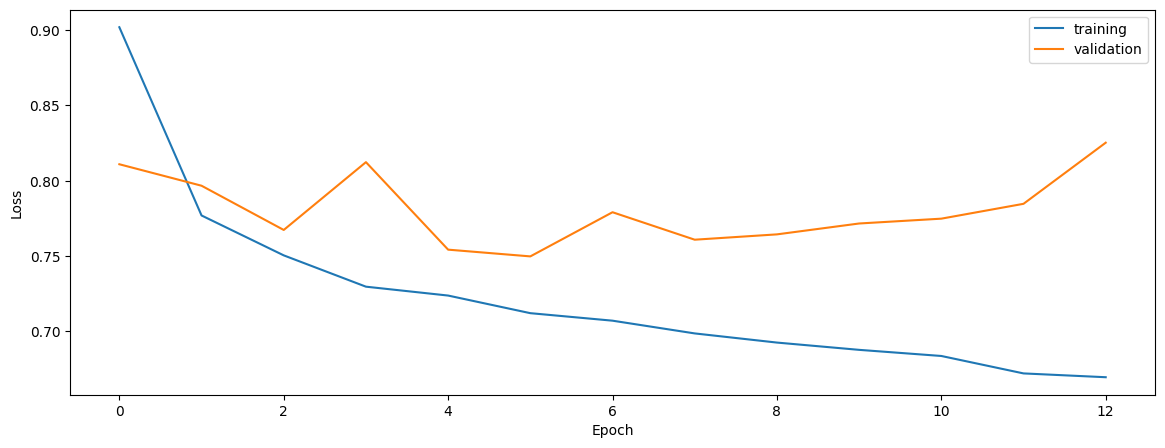

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('train')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.6823707921037389


0.6574825610040712


0.6640316735408855


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.700260163611704


0.6530779707472232


0.6644368316281654


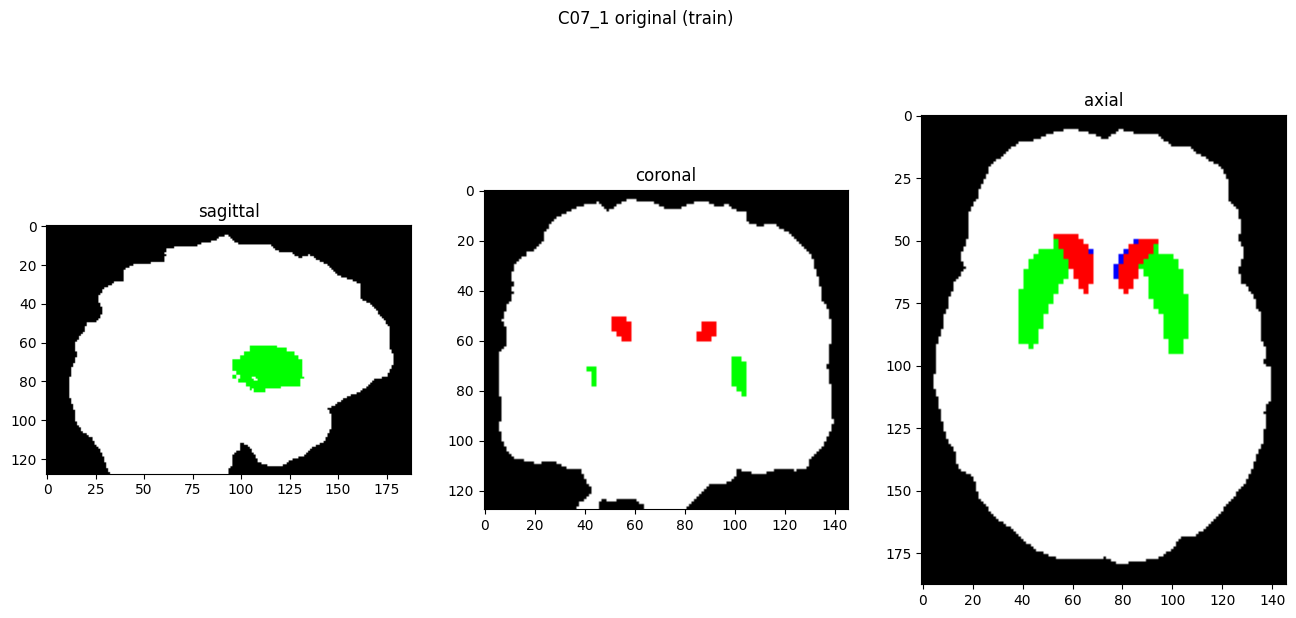

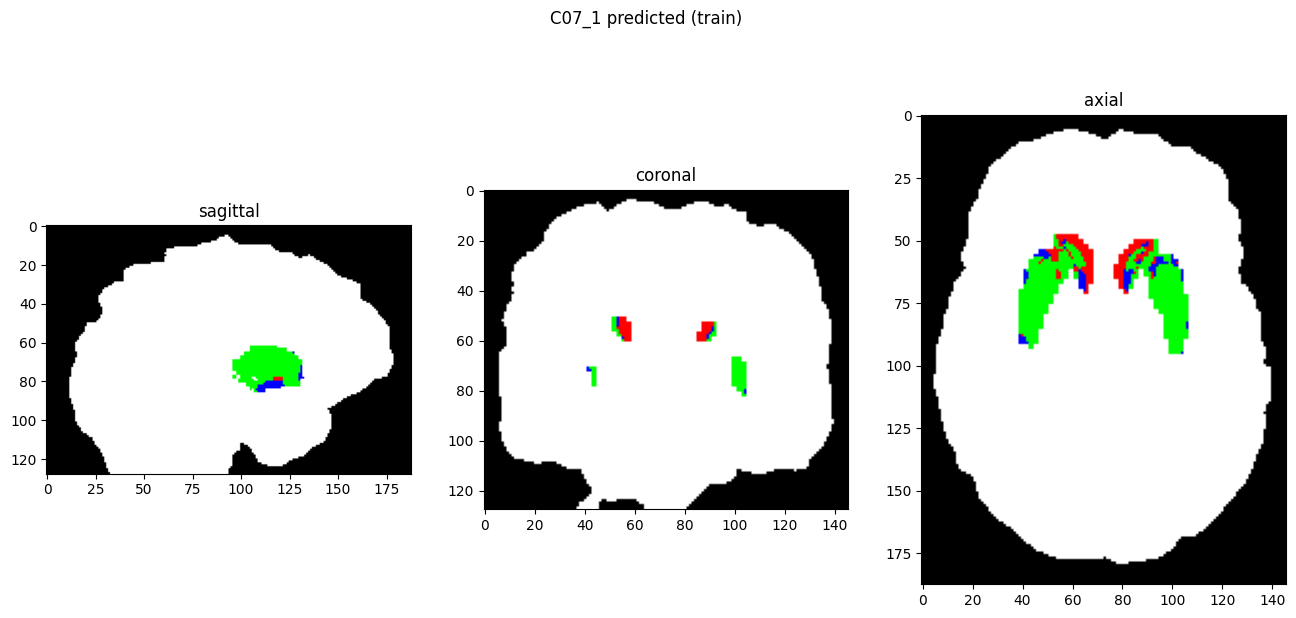

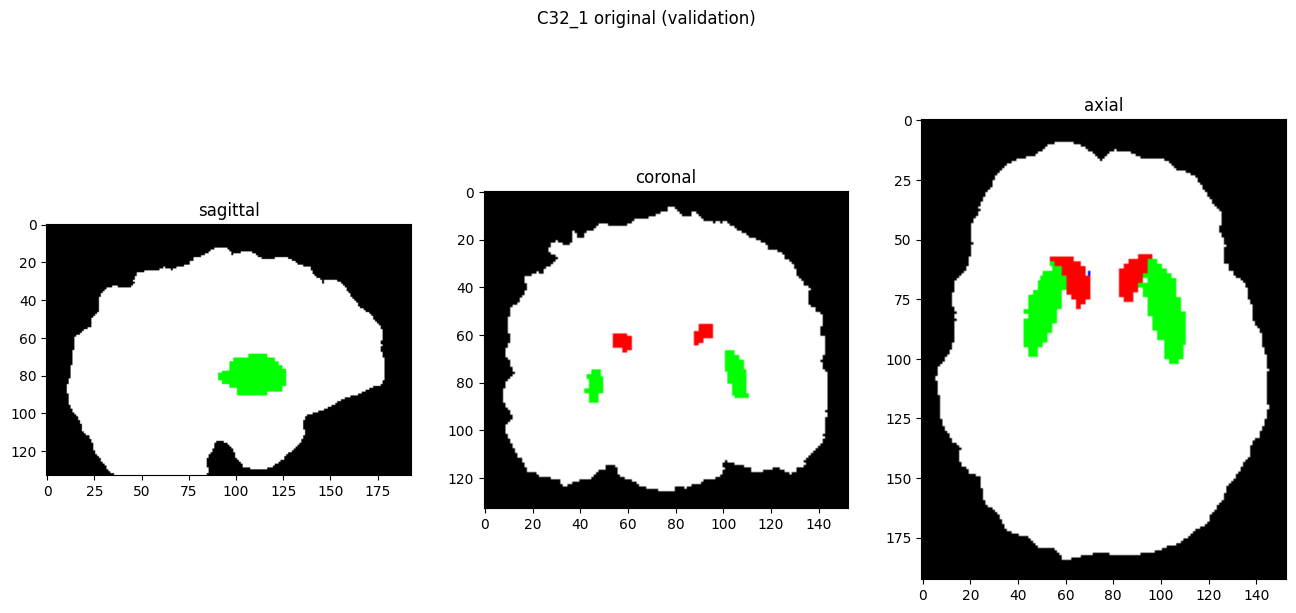

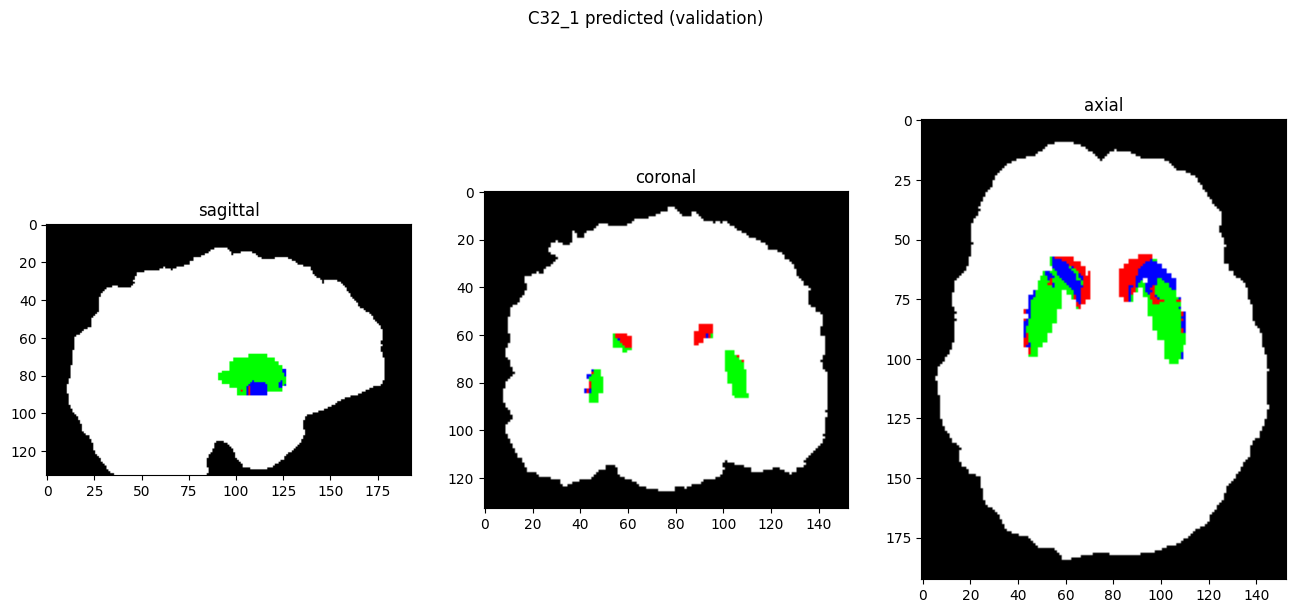

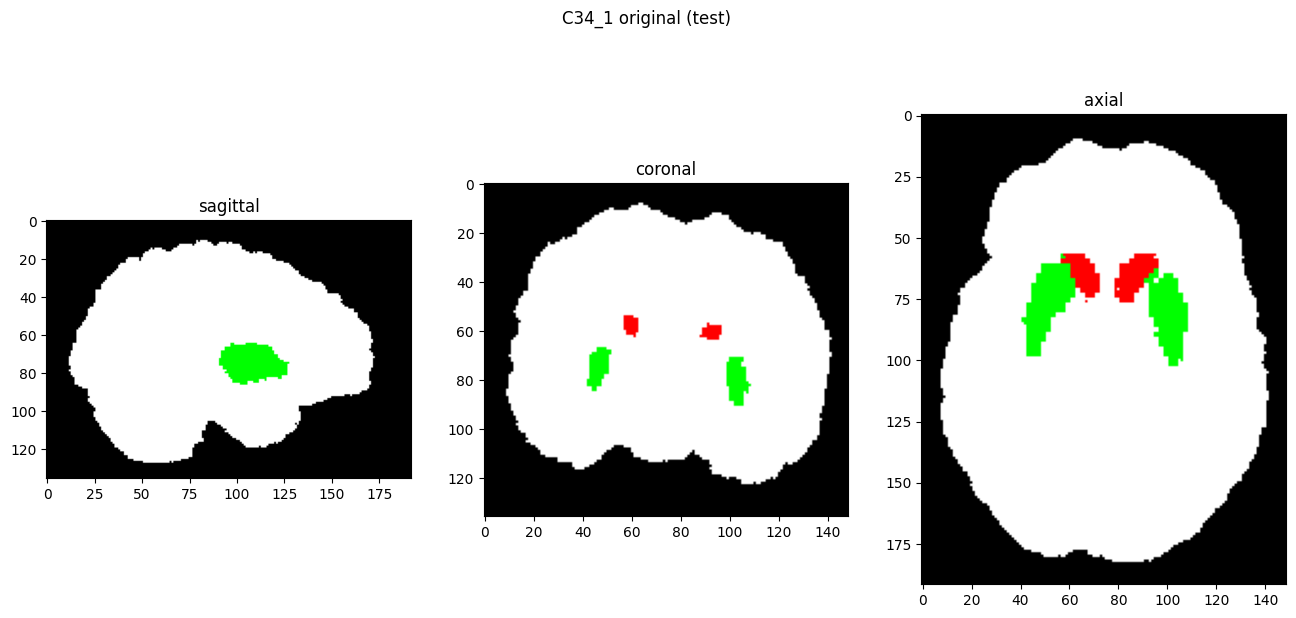

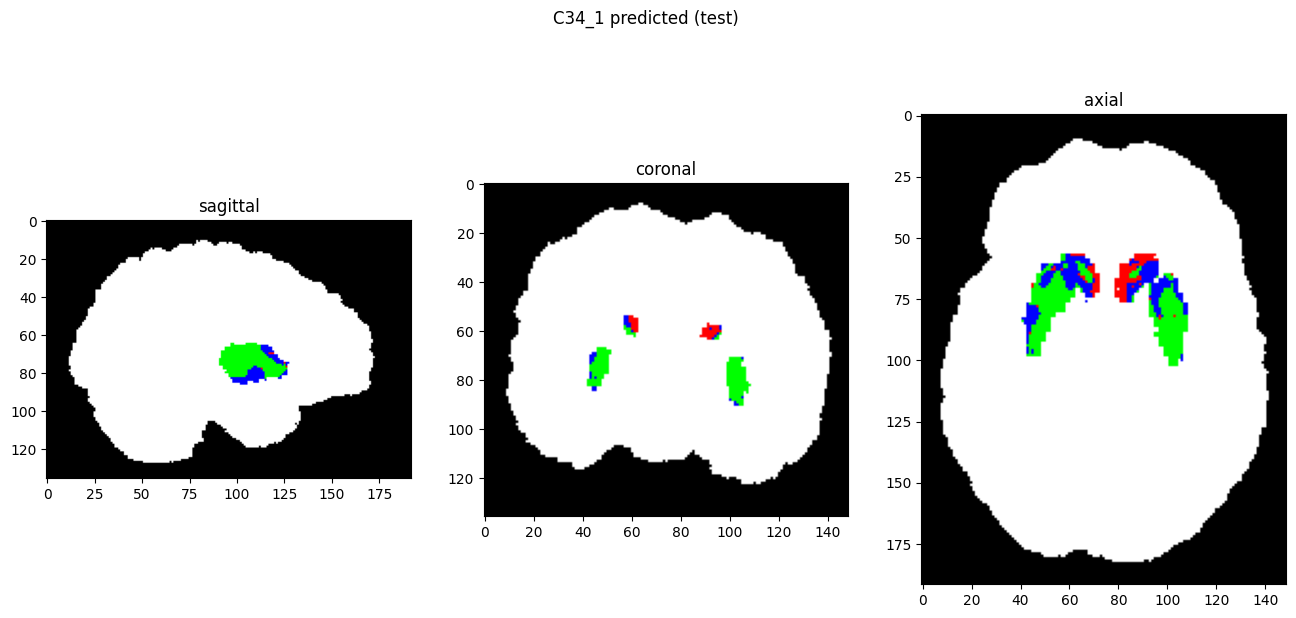

In [9]:
showResults(model, gen, threshold=0)